# Introduction

This project predicts Australian Football League (AFL) match outcomes using machine learning techniques. The dataset was scraped using the fitzRoy package from Footywire and covers detailed player statistics and match information spanning 10 seasons from 2015 to 2025.

With rich game-level and player-level data, including player performance metrics and match results, the project builds predictive models to forecast match winners and analyze key factors influencing game outcomes.

**Goal: Develop an accurate and interpretable model to predict AFL match results.**

# 1. Exploratory Data Analysis

**Imports**

I'll import the core libraries needed for data handling, visualization, and machine learning.

In [246]:
# Standard libraries
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Statistical analysis
from scipy.stats import pointbiserialr, chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    VotingClassifier
)

# Model evaluation and selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve
)

# Explainability
import shap

I'll load the data that was scraped from footywire.

In [181]:
# Player stats data
stats_2015 = pd.read_csv('../data/footywire_player_stats_2015.csv')
stats_2016 = pd.read_csv('../data/footywire_player_stats_2016.csv')
stats_2017 = pd.read_csv('../data/footywire_player_stats_2017.csv')
stats_2018 = pd.read_csv('../data/footywire_player_stats_2018.csv')
stats_2019 = pd.read_csv('../data/footywire_player_stats_2019.csv')
stats_2020 = pd.read_csv('../data/footywire_player_stats_2020.csv')
stats_2021 = pd.read_csv('../data/footywire_player_stats_2021.csv')
stats_2022 = pd.read_csv('../data/footywire_player_stats_2022.csv')
stats_2023 = pd.read_csv('../data/footywire_player_stats_2023.csv')
stats_2024 = pd.read_csv('../data/footywire_player_stats_2024.csv')
stats_2025 = pd.read_csv('../data/footywire_player_stats_2025.csv')

# Game results data
games_2015 = pd.read_csv('../data/footywire_match_results_2015.csv')
games_2016 = pd.read_csv('../data/footywire_match_results_2016.csv')
games_2017 = pd.read_csv('../data/footywire_match_results_2017.csv')
games_2018 = pd.read_csv('../data/footywire_match_results_2018.csv')
games_2019 = pd.read_csv('../data/footywire_match_results_2019.csv')
games_2020 = pd.read_csv('../data/footywire_match_results_2020.csv')
games_2021 = pd.read_csv('../data/footywire_match_results_2021.csv')
games_2022 = pd.read_csv('../data/footywire_match_results_2022.csv')
games_2023 = pd.read_csv('../data/footywire_match_results_2023.csv')
games_2024 = pd.read_csv('../data/footywire_match_results_2024.csv')
games_2025 = pd.read_csv('../data/footywire_match_results_2025.csv')

In [182]:
# Concatenate the yearly datasets into two dataframes representing every year 
stats = pd.concat([stats_2015, stats_2016, stats_2017, stats_2018, stats_2019, stats_2020, stats_2021, stats_2022, stats_2023, stats_2024, stats_2025], ignore_index=True)
games = pd.concat([games_2015, games_2016, games_2017, games_2018, games_2019, games_2020, games_2021, games_2022, games_2023, games_2024, games_2025], ignore_index=True)

**Data Inspection – Games Dataset**

Date (Datetime) – The date the match was played.

Time (Nominal) – The scheduled start time of the match (24-hour format).

Round (Nominal) – The round or week of the competition (e.g., “Round 1”).

Venue (Nominal) – The stadium where the match took place.

Home.Team (Nominal) – The team playing as the home side.

Away.Team (Nominal) – The team playing as the away side.

Home.Points (Numeric) – The total points scored by the home team in that match.

Away.Points (Numeric) – The total points scored by the away team in that match.

In [183]:
games.head()

,Date,Time,Round,Venue,Home.Team,Away.Team,Home.Points,Away.Points
0,2015-04-02,19:20,Round 1,MCG,Carlton,Richmond,78,105
1,2015-04-04,13:40,Round 1,MCG,Melbourne,Gold Coast,115,89
2,2015-04-04,16:35,Round 1,Accor Stadium,Sydney,Essendon,72,60
3,2015-04-04,18:20,Round 1,Gabba,Brisbane,Collingwood,74,86
4,2015-04-04,19:20,Round 1,Marvel Stadium,Western Bulldogs,West Coast,97,87


In [184]:
games.tail()

,Date,Time,Round,Venue,Home.Team,Away.Team,Home.Points,Away.Points
2205,2025-07-25,19:50,Round 20,ENGIE Stadium,GWS,Sydney,102,58
2206,2025-07-26,13:20,Round 20,People First Stadium,Gold Coast,Brisbane,130,64
2207,2025-07-26,14:15,Round 20,Optus Stadium,Fremantle,West Coast,126,77
2208,2025-07-26,19:35,Round 20,Marvel Stadium,North Melbourne,Geelong,49,150
2209,2025-07-26,19:40,Round 20,Adelaide Oval,Adelaide,Port Adelaide,133,35


I’ll start with a quick, high-level review of the dataset to gauge its completeness and variety, while also checking for potential issues such as duplicates or anomalies, before moving on to more detailed analysis and preprocessing.

In [185]:
# Shape of dataset
print(f"Shape: {games.shape}")

# Data types
print("\nData types:")
print(games.dtypes)

# Total missing values
total_missing = games.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

# Duplicate rows
duplicate_count = games.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

# Unique venue count
print(f"Unique Venues: {games['Venue'].nunique()}")

# Unique team count
print(f"Unique Teams: {games['Home.Team'].nunique()}")

games.describe()

Shape: (2210, 8)

Data types:
Date           object
Time           object
Round          object
Venue          object
Home.Team      object
Away.Team      object
Home.Points     int64
Away.Points     int64
dtype: object

Total missing values: 0
Duplicate rows: 0
Unique Venues: 25
Unique Teams: 18


,Home.Points,Away.Points
count,2210.000000,2210.000000
mean,85.533484,79.432127
std,26.258423,25.130338
min,16.000000,14.000000
25%,67.000000,62.000000
50%,84.000000,78.000000
75%,103.000000,95.000000
max,205.000000,173.000000


Home advantage is evident, with home teams scoring an average of 85.5 points compared to 79.4 points for away teams.

Date and time information can be used to calculate the rest period each team had before a match, which may influence performance.

Potential features for the predictive model include each team’s historical win rate at specific venues and the exact number of rest days between matches.

The representation of finals within the Round column will also be reviewed to ensure it is handled appropriately during preprocessing.

In [186]:
# Show all unique rounds
games['Round'].unique()

array(['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Round 5', 'Round 6',
       'Round 7', 'Round 8', 'Round 9', 'Round 10', 'Round 11',
       'Round 12', 'Round 13', 'Round 14', 'Round 15', 'Round 16',
       'Round 17', 'Round 18', 'Round 19', 'Round 20', 'Round 21',
       'Round 22', 'Round 23', 'Qualifying Final', 'Elimination Final',
       'Semi Final', 'Preliminary Final', 'Grand Final',
       'Preliminary Finals', 'Round 24', 'Round 0'], dtype=object)

The Round values will be converted to integers during the data cleaning stage to enable calculations based on the number of previous rounds a team has played.

**Data Inspection (Stats)**

The stats dataset contains variables describing player performance and match details in AFL games:

Date (Datetime) – Date when the match was played.

Season (Numeric) – Year of the AFL season.

Round (Numeric) – Round number within the season.

Venue (Nominal) – Stadium where the match took place.

Player (Nominal) – Name of the player.

Team (Nominal) – Player’s team.

Opposition (Nominal) – Opposing team in the match.

Status (Nominal) – Home or away status of the player’s team.

Match_id (Nominal) – Unique identifier for each match.


Performance Metrics:

GA (Numeric) – Goal assists.

CP (Numeric) – Contested possessions gained.

UP (Numeric) – Uncontested possessions gained.

ED (Numeric) – Effective disposals (successful passes).

DE (Numeric) – Disposal efficiency.

CM (Numeric) – Contested marks.

MI5 (Numeric) – Marks inside 50.

One.Percenters (Numeric) – Defensive efforts like spoils or smothers.

BO (Numeric) – Number of bounces while running.

TOG (Numeric) – Time on ground (minutes played).

K (Numeric) – Kicks delivered.

HB (Numeric) – Handballs delivered.

D (Numeric) – Total disposals (kicks + handballs).

M (Numeric) – Marks (catches from kicks).

G (Numeric) – Goals scored by the player.

B (Numeric) – Behinds scored.

T (Numeric) – Tackles made.

HO (Numeric) – Hitouts in ruck contests.

I50 (Numeric) – Inside 50-meter entries.

CL (Numeric) – Clearances from stoppages.

CG (Numeric) – Clangers.

R50 (Numeric) – Rebound 50-meter exits.

FF (Numeric) – Free kicks awarded to player.

FA (Numeric) – Free kicks against player.

AF (Numeric) – AFL fantasy.

SC (Numeric) – Super coach.

CCL (Numeric) – Centre clearances.

SCL (Numeric) – Scores from clearances.

SI (Numeric) – Score involvements.

MG (Numeric) – Meters gained from disposals.

TO (Numeric) – Turnovers conceded.

ITC (Numeric) – Times in interchange.

T5 (Numeric) – Times among top 5 possessions on team.

In [187]:
stats.head()

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,GA,...,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5
0,2015-04-02,2015,Round 1,MCG,Bryce Gibbs,Carlton,Richmond,Home,5964,0.0,...,2.0,96.0,82.0,2.0,2.0,8.0,466.0,6.0,3.0,0.0
1,2015-04-02,2015,Round 1,MCG,Tom Bell,Carlton,Richmond,Home,5964,2.0,...,0.0,108.0,115.0,0.0,1.0,10.0,475.0,4.0,1.0,3.0
2,2015-04-02,2015,Round 1,MCG,Sam Docherty,Carlton,Richmond,Home,5964,1.0,...,0.0,107.0,147.0,0.0,2.0,6.0,287.0,2.0,12.0,1.0
3,2015-04-02,2015,Round 1,MCG,Chris Judd,Carlton,Richmond,Home,5964,4.0,...,2.0,93.0,108.0,4.0,2.0,8.0,474.0,5.0,2.0,1.0
4,2015-04-02,2015,Round 1,MCG,Kade Simpson,Carlton,Richmond,Home,5964,0.0,...,0.0,97.0,103.0,0.0,0.0,4.0,269.0,4.0,5.0,0.0


In [188]:
stats.tail()

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,GA,...,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5
99263,2025-07-26,2025,Round 20,Optus Stadium,Sandy Brock,West Coast,Fremantle,Away,11357,0.0,...,0.0,30.0,41.0,0.0,0.0,2.0,163.0,1.0,1.0,0.0
99264,2025-07-26,2025,Round 20,Optus Stadium,Jobe Shanahan,West Coast,Fremantle,Away,11357,0.0,...,0.0,34.0,15.0,0.0,0.0,1.0,10.0,3.0,0.0,1.0
99265,2025-07-26,2025,Round 20,Optus Stadium,Matt Owies,West Coast,Fremantle,Away,11357,0.0,...,0.0,16.0,25.0,0.0,0.0,0.0,7.0,0.0,1.0,1.0
99266,2025-07-26,2025,Round 20,Optus Stadium,Tyrell Dewar,West Coast,Fremantle,Away,11357,0.0,...,0.0,15.0,10.0,0.0,0.0,1.0,50.0,0.0,0.0,0.0
99267,2025-07-26,2025,Round 20,Optus Stadium,Archer Reid,West Coast,Fremantle,Away,11357,0.0,...,0.0,7.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


I will perform the same high-level overview on the stats dataframe as was done for the games dataframe.

In [189]:
# Shape of dataset
print(f"Shape: {stats.shape}")

# Data types
print("\nData types:")
print(stats.dtypes)

# Total missing values
total_missing = stats.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

# Duplicate rows
duplicate_count = stats.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

# Unique player count
print(f"Unique Players: {stats['Player'].nunique()}")

stats.describe()

Shape: (99268, 42)

Data types:
Date               object
Season              int64
Round              object
Venue              object
Player             object
Team               object
Opposition         object
Status             object
Match_id            int64
GA                float64
CP                float64
UP                float64
ED                float64
DE                float64
CM                float64
MI5               float64
One.Percenters    float64
BO                float64
TOG               float64
K                 float64
HB                float64
D                 float64
M                 float64
G                 float64
B                 float64
T                 float64
HO                float64
I50               float64
CL                float64
CG                float64
R50               float64
FF                float64
FA                float64
AF                float64
SC                float64
CCL               float64
SCL               float64
SI    

,Season,Match_id,GA,CP,UP,ED,DE,CM,MI5,One.Percenters,...,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5
count,99268.000000,99268.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,...,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000,98871.000000
mean,2020.003606,9618.381754,0.370715,6.117962,9.851321,11.727595,72.127812,0.474558,0.507874,2.094537,...,0.835007,68.396365,73.764774,0.533857,1.103043,4.034793,250.858958,3.003044,3.021432,0.480576
std,3.156504,1708.871716,0.660685,3.681863,5.261543,5.768292,14.813611,0.844474,0.968909,2.331714,...,0.980024,27.363854,29.673155,1.062050,1.537628,2.620106,146.658719,2.018134,2.609266,0.845519
min,2015.000000,5964.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-6.000000,-12.000000,0.000000,0.000000,0.000000,-92.000000,0.000000,0.000000,0.000000
25%,2017.000000,9458.000000,0.000000,4.000000,6.000000,7.000000,63.600000,0.000000,0.000000,0.000000,...,0.000000,49.000000,53.000000,0.000000,0.000000,2.000000,143.000000,2.000000,1.000000,0.000000
50%,2020.000000,10259.000000,0.000000,5.000000,9.000000,11.000000,73.300000,0.000000,0.000000,1.000000,...,1.000000,67.000000,72.000000,0.000000,1.000000,4.000000,229.000000,3.000000,2.000000,0.000000
75%,2023.000000,10815.000000,1.000000,8.000000,13.000000,15.000000,82.100000,1.000000,1.000000,3.000000,...,1.000000,86.000000,93.000000,1.000000,2.000000,6.000000,338.000000,4.000000,4.000000,1.000000
max,2025.000000,11394.000000,6.000000,32.000000,37.000000,45.000000,100.000000,9.000000,12.000000,25.000000,...,9.000000,200.000000,229.000000,12.000000,14.000000,21.000000,1169.000000,17.000000,22.000000,9.000000


I will develop a formula to calculate offensive and defensive ratings for each player, weighting individual statistics according to their relative importance. These ratings will then be aggregated at the team level to generate an overall team rating, which I anticipate will be a highly predictive feature.

The dataset contains 13,101 missing values, which will need to be addressed. Additionally, the number of unique players appears unusually high for a 10-year period (~13,000), whereas domain knowledge suggests it should be closer to 1,800. This discrepancy warrants further investigation.

# 1.1 Cleaning the Data

**Missing Values**

I'll examine the missing values in the stats dataframe.

In [190]:
missing_vals = stats[stats.isna().any(axis=1)]
missing_vals.nunique()

Date              159
Season              5
Round              28
Venue              17
Player            231
Team               18
Opposition         18
Status              2
Match_id          301
GA                  0
CP                  0
UP                  0
ED                  0
DE                  0
CM                  0
MI5                 0
One.Percenters      0
BO                  0
TOG                 0
K                   0
HB                  0
D                   0
M                   0
G                   0
B                   0
T                   0
HO                  0
I50                 0
CL                  0
CG                  0
R50                 0
FF                  0
FA                  0
AF                  0
SC                  0
CCL                 0
SCL                 0
SI                  0
MG                  0
TO                  0
ITC                 0
T5                  0
dtype: int64

These missing rows can be removed, as they are distributed across multiple years, teams, and rounds. This dispersion ensures there is no large consecutive block of missing data that could adversely impact model training.

In [191]:
stats = stats.dropna()
stats.isna().sum()

Date              0
Season            0
Round             0
Venue             0
Player            0
Team              0
Opposition        0
Status            0
Match_id          0
GA                0
CP                0
UP                0
ED                0
DE                0
CM                0
MI5               0
One.Percenters    0
BO                0
TOG               0
K                 0
HB                0
D                 0
M                 0
G                 0
B                 0
T                 0
HO                0
I50               0
CL                0
CG                0
R50               0
FF                0
FA                0
AF                0
SC                0
CCL               0
SCL               0
SI                0
MG                0
TO                0
ITC               0
T5                0
dtype: int64

**Player Count**

As noted earlier, the dataset contains 2,724 unique players, which appears excessive for a 10-year period. This will be investigated further to confirm its accuracy.

In [192]:
pd.DataFrame(stats['Player'].unique())

,0
0,Bryce Gibbs
1,Tom Bell
2,Sam Docherty
3,Chris Judd
4,Kade Simpson
...,...
2718,Ben Jepson
2719,Daniel Rioli ↗
2720,Leo Lombard
2721,Zac Banch


There is an arrow symbol next to Daniel Rioli’s name, which likely indicates that he was subbed on during the game. Such characters will need to be removed, as they create duplicates of the same player name. Since I plan to aggregate the average statistics for each player, it is important to retain the data from matches where players were subbed on or off.

In [193]:
# Remove any characters from 'Player' names that are unusual
stats['Player'] = stats['Player'].str.replace(r"[^\w\s'-]", '', regex=True).str.strip()

# Count the number of unique player names
stats['Player'].nunique()

1537

This revised number appears to be more reasonable.

**Irrelevant Columns**

The AFL Fantasy and SuperCoach columns in the stats data will be dropped, as they are derived from other statistics already present in the dataset. Since I plan to calculate my own player rating based on these underlying statistics, these columns do not add value to the model.

In [194]:
stats = stats.drop(columns=['AF', 'SC'])

**Winner Column**

A new column indicating the winner of each game will be required to facilitate analysis.

In [195]:
# Flag if the home team won (1) or not (0)
games['HomeWin'] = (games['Home.Points'] > games['Away.Points']).astype(int)

# Flag if the away team won (1) or not (0)
games['AwayWin'] = (games['Away.Points'] > games['Home.Points']).astype(int)

# Determine the winner's name, or 'Draw' if points are equal
games['Winner'] = np.where(games['HomeWin'], games['Home.Team'],
                           np.where(games['AwayWin'], games['Away.Team'], 'Draw'))

**Season and Match_id**

Columns indicating the current season and the match_id in the games dataframe are required to enable merging with the stats dataframe for analysis.

In [196]:
# Convert 'Date' to datetime and extract 'Season'
games['Date'] = pd.to_datetime(games['Date'])
games['Season'] = games['Date'].dt.year

# Prepare stats subset for merging (rename 'Team' to 'Home.Team')
merge_stats = stats[['Match_id', 'Round', 'Team', 'Season']].rename(columns={'Team': 'Home.Team'})

# Merge, drop duplicates, and reset index
games = games.merge(merge_stats, on=['Round', 'Home.Team', 'Season']).drop_duplicates().reset_index(drop=True)

**Finals and Rounds**

The Round column will be converted to a numeric identifier to enable easier processing in later stages of analysis. Finals rounds will be standardized to match the regular season format by mapping them to rounds 25, 26, 27 and 28.

In [197]:
# Map finals round names to numeric values
finals_map = {
    'Qualifying Final': 25,
    'Elimination Final': 25,
    'Semi Final': 26,
    'Preliminary Final': 27,
    'Preliminary Finals': 27,
    'Grand Final': 28
}

# Apply finals mapping to games
games['Round'] = games['Round'].replace(finals_map)
games['Round'] = games['Round'].replace(r'Round (\d+)', r'\1', regex=True).astype(int)

# Apply finals mapping to stats
stats['Round'] = stats['Round'].replace(finals_map)
stats['Round'] = stats['Round'].replace(r'Round (\d+)', r'\1', regex=True).astype(int)

**Start Time Categories**

To better explore the relationship between game start time and match outcomes, I will categorize each game into one of three distinct time bins: Afternoon, Evening, and Night. This classification will provide a clearer structure for analysis and make it easier to identify potential patterns or trends related to the timing of matches.

In [198]:
# Extract the hour from the 'Time' column 
hour = games['Time'].str.split(':').str[0].astype(int)

# Categorise each game based on start time
games['TimeCategory'] = pd.cut(
    hour,
    bins=[0, 15, 18, 24],
    labels=['Afternoon', 'Evening', 'Night'],
    right=False
)

**Marvel Stadium Fix**

When predicting outcomes, I noticed that the venue 'Marvel Stadium' was incorrectly recorded as ' Marvel Stadium'. This formatting issue needs to be corrected to ensure consistency in the data.

In [199]:
stats['Venue'] = stats['Venue'].replace({' Marvel Stadium': 'Marvel Stadium'})
games['Venue'] = games['Venue'].replace({' Marvel Stadium': 'Marvel Stadium'})

# 1.2 Feature Exploration

**Game Start Time**

I will investigate whether the scheduled start time of a game has a measurable impact on the likelihood of a team winning.

In [227]:
# Create an empty list to store chi-squared test results for each team
results = []

# Loop through every unique team in the dataset
for team in games['Home.Team'].unique():
    
    # Filter games where the current team was either home or away
    team_df = games[(games['Home.Team'] == team) | (games['Away.Team'] == team)].copy()
    
    # Create a binary column: 1 if the team won, 0 if they lost
    team_df['Won'] = (team_df['Winner'] == team).astype(int)
    
    # Group by time category and count wins and total matches
    # observed=False ensures that all categories (Afternoon, Evening, Night) are kept, even if absent
    team_df = team_df.groupby('TimeCategory', as_index=False, observed=False).agg({
        'Won': 'sum', 
        'Match_id': 'count'
    })

    # Calculate losses as total matches minus wins
    team_df['Lost'] = team_df['Match_id'] - team_df['Won']
    
    # Prepare the contingency table for chi-squared test (TimeCategory x Won/Lost)
    contingency_table = team_df.drop(columns='Match_id').set_index('TimeCategory')

    # Perform chi-squared test of independence
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Store results with Bonferroni correction (multiply p-value by number of tests = 18 teams)
    results.append({'Team': team, 'Chi2': chi2, 'p_value': p * 18})

# Convert results to DataFrame and sort by adjusted p-value
results = pd.DataFrame(results).sort_values(by='p_value')

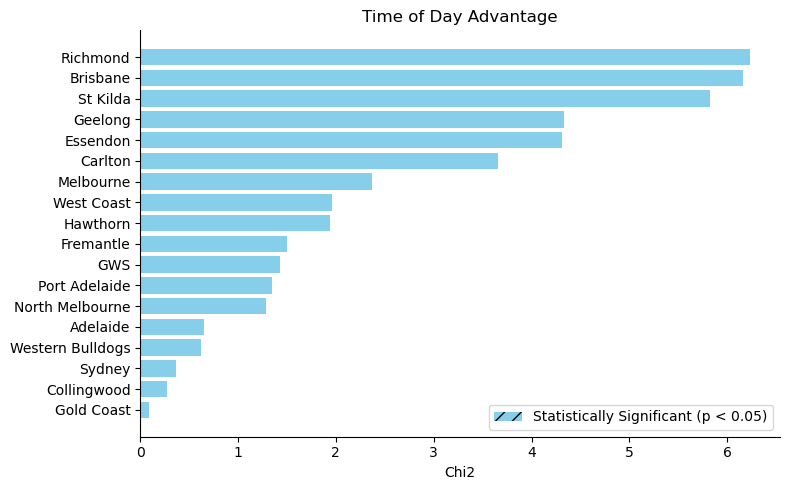

In [226]:
# Sort results by Chi2
results_sorted = results.sort_values(by="Chi2", ascending=True)

labels = results_sorted['Team']
values = results_sorted['Chi2']
pvals  = results_sorted['p_value']
alpha = 0.05

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(labels, values, color='skyblue')

# Highlight significant bars
for bar, p in zip(bars, pvals):
    if p < alpha:
        bar.set_hatch('//')
        bar.set_linewidth(1.5)

# Add legend
sig_patch = mpatches.Patch(facecolor='skyblue', hatch='//', label=f'Significant (p < {alpha})')
ax.legend(handles=[sig_patch])

# Labels and style
ax.set_xlabel("Chi2")
ax.set_title("Time of Day Advantage")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

There’s no statistically significant evidence that start time affects the likelihood of winning for any individual team.

**Home Team Advantage**

I will investigate whether playing at home has any influence on the outcome of the winner for each team.

In [218]:
# Initialize an empty list to store results for each team
results = []

# Loop through every unique team in the dataset
for team in games['Home.Team'].unique():
    
    # Filter games where the current team was either home or away
    team_df = games[(games['Home.Team'] == team) | (games['Away.Team'] == team)].copy()
        
    # Create a binary column: 1 if the team won, 0 if they lost
    team_df['Won'] = (team_df['Winner'] == team).astype(int)
    
    # Label each game as 'Home' or 'Away' for the current team
    team_df['Location'] = np.where(team_df['Home.Team'] == team, 'Home', 'Away')
    
    # Aggregate wins and total games by location
    team_df = team_df.groupby('Location', as_index=False, observed=False)[['Won', 'Match_id']].agg({
        'Won': 'sum', 
        'Match_id': 'count'
    })
    
    # Calculate losses as total games minus wins
    team_df['Lost'] = team_df['Match_id'] - team_df['Won']
    
    # Prepare contingency table with wins and losses indexed by location
    contingency_table = team_df.drop(columns='Match_id').set_index('Location')
    
    # Perform Chi-squared test to see if win/loss depends on location
    chi2, p, _, _ = chi2_contingency(contingency_table)
        
    # Store results and apply Bonferroni correction for multiple tests
    results.append({'Team': team, 'Chi2': chi2, 'p_value': p * 18})

# Convert results to DataFrame and sort by adjusted p-value
results = pd.DataFrame(results).sort_values(by='p_value')

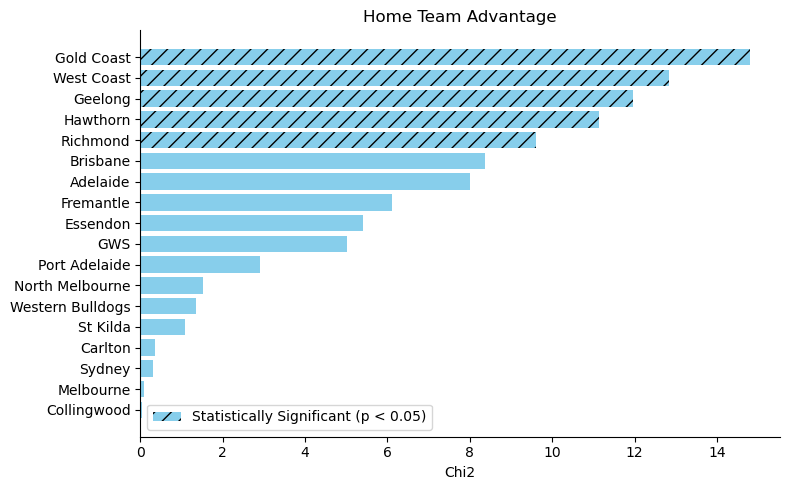

In [219]:
# Sort results by Chi2 descending
results_sorted = results.sort_values(by="Chi2", ascending=False)

labels = results_sorted['Team']
values = results_sorted['Chi2']
pvals  = results_sorted['p_value']
alpha = 0.05

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(labels, values, color='skyblue')

# Highlight significant bars
for bar, p in zip(bars, pvals):
    if p < alpha:
        bar.set_hatch('//')
        bar.set_linewidth(1.5)

# Add legend
sig_patch = mpatches.Patch(facecolor='skyblue', hatch='//', label=f'Statistically Significant (p < {alpha})')
ax.legend(handles=[sig_patch])

# Labels and style
ax.set_xlabel("Chi2")
ax.set_title("Home Team Advantage")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

Only five teams—Gold Coast, West Coast, Geelong, Hawthorn, and Richmond—show a statistically significant home advantage after Bonferroni correction, with p-values below 0.05. Their Chi-squared statistics highlight a notable deviation from the “no home advantage” expectation, while all other teams show no strong evidence of an advantage at home. Overall, there is a small but meaningful home team effect in the AFL. 

To account for shared stadiums, I will calculate each team’s win rate at a venue based on their last five games, capturing both home advantage and away disadvantage. Teams with exclusive grounds, like Gold Coast and Geelong, naturally exhibit stronger home advantage.

The get_last_5_venue function calculates each team’s recent form at the venue by computing their win rate over the last five games played there. It captures both home advantage and away disadvantage, giving a more precise measure of performance at each stadium.

The add_venue_columns function adds each team’s venue win rates into a new column.

In [21]:
def get_last_5_venue(matchid, home_team, away_team, games):
    # Get the venue of the current game
    venue = games.loc[games['Match_id'] == matchid, 'Venue'].values[0]

    # Filter all games involving either team at that venue
    venue_games = games[
        ((games['Home.Team'] == home_team) | (games['Away.Team'] == home_team) |
         (games['Home.Team'] == away_team) | (games['Away.Team'] == away_team)) &
        (games['Venue'] == venue)
    ].copy()

    # Sort games by season and round to get chronological order
    venue_games = venue_games.sort_values(['Season', 'Round'])

    # Get last 5 games at venue for home team, excluding current match
    home_venue_games = venue_games[
        ((venue_games['Home.Team'] == home_team) | (venue_games['Away.Team'] == home_team)) &
        (venue_games['Match_id'] != matchid)
    ].tail(5)

    # Get last 5 games at venue for away team, excluding current match
    away_venue_games = venue_games[
        ((venue_games['Home.Team'] == away_team) | (venue_games['Away.Team'] == away_team)) &
        (venue_games['Match_id'] != matchid)
    ].tail(5)

    # Calculate home team's win rate at this venue
    home_wins = (
        ((home_venue_games['Home.Team'] == home_team) & (home_venue_games['HomeWin'] == 1)) |
        ((home_venue_games['Away.Team'] == home_team) & (home_venue_games['AwayWin'] == 1))
    )
    home_winrate = home_wins.astype(int).mean() if not home_venue_games.empty else 0.0

    # Calculate away team's win rate at this venue
    away_wins = (
        ((away_venue_games['Home.Team'] == away_team) & (away_venue_games['HomeWin'] == 1)) |
        ((away_venue_games['Away.Team'] == away_team) & (away_venue_games['AwayWin'] == 1))
    )
    away_winrate = away_wins.astype(int).mean() if not away_venue_games.empty else 0.0

    # Return home and away win rates at venue
    return [home_winrate, away_winrate]

In [22]:
def add_venue_columns(games: pd.DataFrame, years) -> pd.DataFrame:
    # Filter games to only include the specified seasons
    games_subset = games[games['Season'].isin(years)].copy()

    # Compute venue win rates for the last 5 games at the home team's venue
    venue_winrates = games_subset.apply(
        lambda row: pd.Series(
            get_last_5_venue(row['Match_id'], row['Home.Team'], row['Away.Team'], games)
        ),
        axis=1
    )

    # Assign meaningful column names to the resulting Series
    venue_winrates.columns = ['HomeVenueWinRate', 'AwayVenueWinRate']

    # Add the new venue win rate columns to the dataframe
    games_subset[['HomeVenueWinRate', 'AwayVenueWinRate']] = venue_winrates

    # Compute net venue win rates: home minus away, and vice versa
    games_subset['HomeNetVenueWinrate'] = games_subset['HomeVenueWinRate'] - games_subset['AwayVenueWinRate']
    games_subset['AwayNetVenueWinrate'] = games_subset['AwayVenueWinRate'] - games_subset['HomeVenueWinRate']
    
    # Return the dataframe with the new venue-related columns
    return games_subset

In [24]:
venues = add_venue_columns(games, list(range(2020, 2026)))

I will test if a team’s net venue win rate predicts wins using point-biserial correlation.

In [25]:
# Compute point-biserial correlation between HomeWin and HomeNetVenueWinrate
corr, p_val = pointbiserialr(venues['HomeWin'], venues['HomeNetVenueWinrate'])
print(f"Correlation: {corr}, p-value: {p_val}")

Correlation: 0.21200451497394496, p-value: 2.0396870829634065e-13


The correlation (0.21) is small but highly significant (p ≈ 2×10⁻¹³), confirming that net venue win rate reliably predicts home wins. This justifies using it as a feature.

**Winrate Against Opposition**

I will investigate how much a team’s recent win rate against a specific opponent predicts the match outcome.

The get_last_5_matchups function calculates each team’s win rate over their last 5 head-to-head matchups, providing a feature that captures historical performance between the two teams.

The add_matchup_columns function adds columns for each team’s win rate in their last 5 head-to-head matchups, giving a historical performance feature for each game.

In [23]:
def get_last_5_matchups(matchid, team1, team2, games):
    # Filter the games df to have only the matchups between the two teams
    team_games = games[((games['Home.Team'] == team1) & (games['Away.Team'] == team2)
                       ) | ((games['Home.Team'] == team2) & (games['Away.Team'] == team1))].copy()

    # Filter the df to only keep the games prior to the current game
    current = team_games.index[team_games['Match_id'] == matchid][0]
    team_games = team_games.loc[:current - 1] 

    # Remove the current game from the df to calculate previous matchup winrate
    team_games = team_games.tail(6).iloc[:-1]

    # Create new columns containing the wins for each team
    team_games['Team1Win'] = ((team_games['Away.Team'] == team1) & (team_games['AwayWin'] == True)
                             ) | ((team_games['Home.Team'] == team1) & (team_games['HomeWin'] == True))
    team_games['Team2Win'] = ((team_games['Away.Team'] == team2) & (team_games['AwayWin'] == True)
                             ) | ((team_games['Home.Team'] == team2) & (team_games['HomeWin'] == True))

    # Calculate the winrate from these columns
    team1winrate = float(team_games['Team1Win'].astype(int).mean())
    team2winrate = float(team_games['Team2Win'].astype(int).mean())
    
    return [team1winrate, team2winrate]

In [24]:
def add_matchup_columns(games: pd.DataFrame, years) -> pd.DataFrame:
    # Filter games to only include the specified seasons
    games_subset = games[games['Season'].isin(years)].copy()
  
    # Compute win rates for the last 5 matchups between the home and away teams
    matchup_winrates = games_subset.apply(
        lambda row: pd.Series(
            get_last_5_matchups(row['Match_id'], row['Home.Team'], row['Away.Team'], games)
        ),
        axis=1
    )
    
    # Assign meaningful column names to the resulting Series
    matchup_winrates.columns = ['HomeLast5MatchupWinRate', 'AwayLast5MatchupWinRate']

    # Add these new columns back to the games_subset dataframe
    games_subset[['HomeLast5MatchupWinRate', 'AwayLast5MatchupWinRate']] = matchup_winrates
    
    # Return the dataframe with the new matchup columns
    return games_subset

In [28]:
matchups = add_matchup_columns(games, list(range(2020, 2026)))

Now I will calculate the point-biserial correlation between the home team winning and their win rate in the last 5 matchups against the same opponent.

In [29]:
# Compute point-biserial correlation between HomeWin and HomeLast5MatchupWinRate
corr, p_val = pointbiserialr(matchups['HomeWin'], matchups['HomeLast5MatchupWinRate'])
print(f"Correlation: {corr}, p-value: {p_val}")

Correlation: 0.10489207177667467, p-value: 0.0003143633961565997


A team’s winrate in the last five matchups against an opponent shows a weak but statistically significant positive correlation (r = 0.105, p < 0.001) with winning. This suggests recent head-to-head performance slightly predicts wins, so it will be included as a feature in the model.

**Team Form**

Next, I will examine whether a team’s overall winrate over the last 10 games is a significant predictor of match outcomes.

The get_last_10_form function calculates a team’s recent form by computing their win rate over the last 10 games, including games from the previous season if needed. It provides a simple measure of current performance to use as a predictive feature.

The add_winrate_columns function adds each team’s win rate over the last 10 games and their net form (home minus away) as features for predicting match outcomes.

In [25]:
def get_last_10_form(matchid, team, games):
    # Filter all games for the team
    team_games = games[(games['Home.Team'] == team) | (games['Away.Team'] == team)].copy()
    
    # Current match info
    current_round = team_games[team_games['Match_id'] == matchid]['Round'].max()
    current_year = team_games.loc[team_games['Match_id'] == matchid, 'Season'].values[0]

    current_season_rounds = []
    remaining_rounds = 0
    previous_season_needed = False

    # Identify last 10 rounds
    for i in range(1, 11):
        if current_round - i > 0:
            current_season_rounds.append(current_round - i)
        else:
            previous_season_needed = True
            remaining_rounds += 1

    # Include previous season if needed
    if previous_season_needed and current_year != games['Season'].min():
        previous_year = current_year - 1
        previous_season = team_games[team_games['Season'] == previous_year]
        last_round_prev = previous_season['Round'].max()
        previous_season_rounds = [last_round_prev - i for i in range(remaining_rounds)]
        team_games = team_games[
            ((team_games['Season'] == current_year) & (team_games['Round'].isin(current_season_rounds))) |
            ((team_games['Season'] == previous_year) & (team_games['Round'].isin(previous_season_rounds)))
        ]
    else:
        team_games = team_games[(team_games['Season'] == current_year) & (team_games['Round'].isin(current_season_rounds))]

    # Calculate winrate
    team_games['TeamWin'] = ((team_games['Home.Team'] == team) & (team_games['HomeWin'] == True)) | \
                            ((team_games['Away.Team'] == team) & (team_games['AwayWin'] == True))
    return team_games['TeamWin'].mean()

In [26]:
def add_winrate_columns(games: pd.DataFrame, years) -> pd.DataFrame:
    # Filter games to only include the specified seasons
    games_subset = games[games['Season'].isin(years)].copy()

    # Calculate recent form (win rate in last 10 games) for away team
    games_subset['AwayForms'] = games_subset.apply(
        lambda row: get_last_10_form(row['Match_id'], row['Away.Team'], games),
        axis=1
    )
    
    # Calculate recent form (win rate in last 10 games) for home team
    games_subset['HomeForms'] = games_subset.apply(
        lambda row: get_last_10_form(row['Match_id'], row['Home.Team'], games),
        axis=1
    )

    # Compute net form: away team's form minus home team's form
    games_subset['AwayNetForm'] = games_subset['AwayForms'] - games_subset['HomeForms']
    # Compute net form: home team's form minus away team's form
    games_subset['HomeNetForm'] = games_subset['HomeForms'] - games_subset['AwayForms']

    return games_subset 

In [32]:
winrates = add_winrate_columns(games, list(range(2020, 2026)))

I will compute the point-biserial correlation between HomeWin and HomeNetForm (the difference in recent 10-game win rates).

In [33]:
# Compute point-biserial correlation between binary 'HomeWin' and continuous 'HomeNetForm'
corr, p_val = pointbiserialr(winrates['HomeWin'], winrates['HomeNetForm'])
print(f"Correlation: {corr}, p-value: {p_val}")

Correlation: 0.33906149649304457, p-value: 5.0162792780374255e-33


There is a statistically significant positive correlation between HomeNetForm and HomeWin (r = 0.34, p < 0.001), indicating that teams with better recent form are more likely to win. This variable will be used as a feature in the model.

**Days Since Last Game**

Next, I will examine whether a team’s net rest time influences performance. Net rest time is defined as the difference in rest days between the two teams:
Net Rest Time = Home Team Rest Days − Away Team Rest Days.

The days_since_last_game function calculates a team’s rest days since their previous match, capped at 30 days; returns 0 for the first game.

The add_days_columns function computes rest-related features for each game in the specified seasons, including days since the last game for home and away teams, as well as net rest differences between the teams.

In [27]:
def days_since_last_game(match_id, team, games):
    # Ensure Date is in datetime format
    games = games.copy()
    games['Date'] = pd.to_datetime(games['Date'])
    
    # Filter games where team is either Home or Away, sorted by date
    team_games = games[
        (games['Home.Team'] == team) | (games['Away.Team'] == team)
    ].copy().sort_values('Date').reset_index(drop=True)
    
    # Check if any games were found for the team
    if team_games.empty:
        return None
        
    # Find the current game
    current_game = team_games[team_games['Match_id'] == match_id]
    if current_game.empty:
        return None
        
    # Get the index of the current game
    current_index = current_game.index[0]
    
    # If it's the first game, return 0
    if current_index == 0:
        return 0
        
    # Get the previous game
    previous_game = team_games.iloc[current_index - 1]
    
    # Calculate days between current and previous game
    days_diff = (current_game['Date'].iloc[0] - previous_game['Date']).days
    if days_diff > 30:
        days_diff = 30
    return int(days_diff)

In [28]:
def add_days_columns(games, years):
    # Filter games for the specified seasons
    games_subset = games[games['Season'].isin(years)].copy()
    
    # Return early if no games exist for these seasons
    if games_subset.empty:
        return games_subset
    
    # Calculate days since last game for the home team
    games_subset['home_days_since'] = games_subset.apply(
        lambda row: days_since_last_game(row['Match_id'], row['Home.Team'], games),
        axis=1
    )
    
    # Calculate days since last game for the away team
    games_subset['away_days_since'] = games_subset.apply(
        lambda row: days_since_last_game(row['Match_id'], row['Away.Team'], games),
        axis=1
    )
    
    # Compute net days difference: away minus home
    games_subset['away_days_since_net'] = games_subset['away_days_since'] - games_subset['home_days_since']
    
    # Compute net days difference: home minus away
    games_subset['home_days_since_net'] = games_subset['home_days_since'] - games_subset['away_days_since']

    return games_subset

In [36]:
daysbetween = add_days_columns(games, list(range(2020, 2026)))

I will compute the point-biserial correlation between HomeWin and home_days_since_net.

In [37]:
# Compute point-biserial correlation between 'HomeWin' and 'home_days_since_net'
corr, p_val = pointbiserialr(daysbetween['HomeWin'], daysbetween['home_days_since_net'])
print(f"Correlation: {corr}, p-value: {p_val}")

Correlation: 0.018117709984109075, p-value: 0.5347981847504221


The point-biserial correlation between home_days_since_net and HomeWin is near zero (r = 0.018, p = 0.535), suggesting no strong linear relationship. 

(However, this feature was retained as it slightly improved model accuracy in testing, likely due to non-linear interactions with other features).

**Team Ratings**

I will calculate team ratings based on the stats of players from the last 10 games, accounting for which players are available or absent, as this can significantly affect game outcomes. Using logistic regression to find the optimal formula for player rating, I will use this formula to quantify each player’s impact and find the mean of these contributions to produce overall team ratings.

The get_last_10_rounds function retrieves the last 10 rounds of statistics for a given team, accounting for missing or returning players, and handling cases where the 10-game window extends into the previous season. It ensures the data reflects only the most recent games relevant to the specified match.

In [232]:
def get_last_10_rounds(matchid, team, stats):

    # Filter stats for the current team, accounting for missing/returning players if columns exist
    if 'Missing_Players' in stats.columns or 'Returning_Players' in stats.columns:
        team_stats = stats[ 
            ((~stats['Player'].isin(stats['Missing_Players'].iloc[-1])) |  # Keep players not missing
             (stats['Player'].isin(stats['Returning_Players'].iloc[-1])))  # Or players returning
        ].copy()
    else:
        team_stats = stats[(stats['Team'] == team)].copy()  # Only current team stats if no special columns
    
    # Find the latest round for this match
    current = team_stats[team_stats['Match_id'] == matchid]['Round'].max()  

    # If this is a future game (matchid length of 6), copy last round stats to current round
    if len(str(matchid)) == 6:       
        last_round_players = team_stats[team_stats['Round'] == current - 1]  # Get previous round
        last_round_players['Round'] = current  # Assign current round
        last_round_players['Season'] = team_stats['Season'].values[-1]  # Set season
        last_round_players['Match_id'] = matchid  # Set match ID
        team_stats = team_stats[team_stats['Match_id'] != matchid]  # Remove placeholder match
        team_stats = pd.concat([team_stats, last_round_players])  # Add updated last round

    # Initialize variables to track last 10 rounds
    current_season_rounds = []
    remaining_rounds = 0
    previous_season = None
    current_year = team_stats.loc[team_stats['Match_id'] == matchid, 'Season'].values[0]  # Current season
    years = [current_year]  # Start with current season

    # Collect last 10 rounds from current season
    for i in range(1, 11):
        if current-i > -1:
            current_season_rounds.append(current-i)  # Add previous rounds within season
        else:
            previous_season = True  # Not enough rounds in current season
            remaining_rounds += 1  # Count how many rounds to fetch from previous season

    # If previous season rounds are needed and season is not 2015
    if previous_season and current_year != 2015:
        previous_season_rounds = []
        previous_year = current_year - 1  # Last season
        previous_season = team_stats[team_stats['Season'] == previous_year]  # Filter last season
        last_round = previous_season['Round'].max()  # Last round in previous season
        for i in range(0, remaining_rounds + 1):
            previous_season_rounds.append(last_round-i)  # Collect needed rounds
        
        years = [current_year, previous_year]  # Include both seasons
        # Filter team_stats to include only relevant rounds from current and previous season
        team_stats = team_stats[
            ((team_stats['Season'] == current_year) & (team_stats['Round'].isin(current_season_rounds)))
            |
            ((team_stats['Season'] == previous_year) & (team_stats['Round'].isin(previous_season_rounds)))
        ]
        return team_stats  # Return last 10 rounds across both seasons

    else:  
        # Only current season rounds needed
        team_stats = team_stats[
            ((team_stats['Season'] == current_year) & (team_stats['Round'].isin(current_season_rounds)))
        ]
        return team_stats  # Return last 10 rounds from current season

I will use logistic regression to estimate the optimal coefficients for player statistics, allowing me to derive a formula that represents each player’s rating.

I chose not to include “time on ground” in the player rating formula. Weighting the rating by time could artificially inflate the score of players who simply spend more time on the field or unfairly deflate the score of players who make a significant impact in a shorter period.

In [233]:
all_stats = [
    'GA', 'CP', 'UP', 'ED', 'DE', 'CM', 'MI5', 'One.Percenters', 'BO',
    'K', 'HB', 'D', 'M', 'G', 'B', 'T', 'HO', 'I50', 'CL', 'CG', 'R50',
    'FF', 'FA', 'CCL', 'SCL', 'SI', 'MG', 'TO', 'ITC', 'T5'
]

# Average per team per match
avg_stats = stats.groupby(['Match_id', 'Team'], as_index=False)[all_stats].mean()

# Merge with match outcome info
merged = pd.merge(avg_stats, games[['Match_id', 'Home.Team', 'HomeWin']],
                  on='Match_id', how='left')

# Flag which row is home team
merged['Home.Team'] = (merged['Team'] == merged['Home.Team']).astype(int)

# Pivot so we have one row per match with separate home/away columns
wide = merged.pivot(index='Match_id', columns='Home.Team', values=all_stats)

# Rename columns for clarity
wide.columns = [
    f"{stat}_{'Home' if team_flag == 1 else 'Away'}"
    for stat, team_flag in wide.columns
]

# Compute home - away differences for each stat
net_stats = pd.DataFrame({
    stat: wide[f"{stat}_Home"] - wide[f"{stat}_Away"]
    for stat in all_stats
}, index=wide.index)

# Add HomeWin info back
home_win = merged.loc[merged['Home.Team'] == 1, ['Match_id', 'HomeWin']].set_index('Match_id')
net_stats = net_stats.join(home_win).reset_index()

# Prepare features (X) and target (y)
X = net_stats[all_stats]
y = net_stats['HomeWin']

# Logistic regression to see how each stat contributes to win probability
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# Store coefficients
coeff_df = pd.DataFrame({
    'Stat': all_stats,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coeff_df.head(5))
print("Intercept:", model.intercept_[0])


   Stat  Coefficient
13    G     9.664579
0    GA     3.271047
20  R50     2.018598
17  I50     1.380492
18   CL     0.951969
Intercept: -0.04825640354149638


In [234]:
def find_player_score(matchid, team, stats):
    # Get last 10 games for the team
    scores_stats = get_last_10_rounds(matchid, team, stats)
    
    # Average all stats by player
    scores_stats = scores_stats.groupby('Player', as_index=False)[all_stats].mean()
    
    # Calculate weighted overall rating
    scores_stats['OverallRating'] = (
          9.664579  * scores_stats['G'] +
          3.271047  * scores_stats['GA'] +
          2.018598  * scores_stats['R50'] +
          1.380492  * scores_stats['I50'] +
          0.951969  * scores_stats['CL'] +
          0.868372  * scores_stats['SCL'] +
          0.808467  * scores_stats['MI5'] +
          0.752320  * scores_stats['SI'] +
          0.569299  * scores_stats['One.Percenters'] +
          0.428661  * scores_stats['ED'] +
          0.308835  * scores_stats['CCL'] +
          0.247002  * scores_stats['BO'] +
          0.182691  * scores_stats['CP'] +
          0.172831  * scores_stats['T5'] +
          0.166806  * scores_stats['K'] +
          0.127813  * scores_stats['T'] +
          0.065054  * scores_stats['FA'] +
          0.047224  * scores_stats['MG'] +
          0.039307  * scores_stats['ITC'] +
          0.017354  * scores_stats['DE'] +
         -0.002630  * scores_stats['CM'] +
         -0.033898  * scores_stats['HO'] +
         -0.112983  * scores_stats['M'] +
         -0.147042  * scores_stats['D'] +
         -0.307239  * scores_stats['UP'] +
         -0.313848  * scores_stats['HB'] +
         -0.582394  * scores_stats['FF'] +
         -0.783981  * scores_stats['CG'] +
         -1.326969  * scores_stats['B'] +
         -2.216883  * scores_stats['TO'] +
         -0.04825640354149638
    )
    
    # Return player and rating
    return scores_stats[['Player', 'OverallRating']]

In [235]:
find_player_score(11357, 'Fremantle', stats).sort_values(by='OverallRating', ascending=False).head()

,Player,OverallRating
4,Caleb Serong,47.216557
28,Sam Switkowski,39.698521
13,Jordan Clark,37.009085
18,Luke Jackson,33.430239
27,Patrick Voss,33.314712


These results align with expectations based on domain knowledge: Caleb Serong is clearly the standout performer, followed by other key contributors. This supports the accuracy of the rating method, as the rankings are consistent with on-field performance.

I will use machine learning to determine the most effective way to calculate team rating. The following functions calculate the different rating methods I will test.

The add_function_ratings function adds the team ratings for a given rating method to a copy of the games dataframe.

In [236]:
def sum_18_rating(matchid, team, stats):
    # Get player ratings
    player_overall_scores = find_player_score(matchid, team, stats)['OverallRating']
    # Sum top 18 players
    player_rating = float((player_overall_scores.sort_values(ascending=False)[:18]).sum())
    return [matchid, team, player_rating]

def sum_rating(matchid, team, stats):
    # Get player ratings
    player_overall_scores = find_player_score(matchid, team, stats)['OverallRating']
    # Sum all players
    player_rating = float(player_overall_scores.sum())
    return [matchid, team, player_rating]

def mean_18_rating(matchid, team, stats):
    # Get player ratings
    player_overall_scores = find_player_score(matchid, team, stats)['OverallRating']
    # Mean of top 18 players
    player_rating = float((player_overall_scores.sort_values(ascending=False)[:18]).mean())
    return [matchid, team, player_rating]

def mean_rating(matchid, team, stats):
    # Get player ratings
    player_overall_scores = find_player_score(matchid, team, stats)['OverallRating']
    # Mean of all players
    player_rating = float(player_overall_scores.mean())
    return [matchid, team, player_rating]

def std_rating(matchid, team, stats):
    # Get player ratings
    player_overall_scores = find_player_score(matchid, team, stats)['OverallRating']
    # Standard deviation of ratings
    player_rating = np.std(player_overall_scores)
    return [matchid, team, player_rating]

def weighted_rating(matchid, team, stats):
    # Get player ratings sorted by rating
    player_overall_scores = find_player_score(matchid, team, stats).sort_values(
        by='OverallRating', ascending=False
    )

    # Assign weights (top 5 players = 2, rest = 1)
    weights = [2 if i < 5 else 1 for i in range(len(player_overall_scores))]
    player_overall_scores['Weights'] = weights

    # Compute weighted average
    weighted_avg = (player_overall_scores['OverallRating'] * player_overall_scores['Weights']).sum() / sum(weights)

    return [matchid, team, float(weighted_avg)]

In [237]:
def add_function_ratings(function, games: pd.DataFrame, stats: pd.DataFrame, years) -> pd.DataFrame:
    games_subset = games[games['Season'].isin(years)].copy()

    # Compute team ratings once per game/team
    games_subset['AwayStats'] = games_subset.apply(
        lambda row: function(row['Match_id'], row['Away.Team'], stats),
        axis=1
    )
    games_subset['HomeStats'] = games_subset.apply(
        lambda row: function(row['Match_id'], row['Home.Team'], stats),
        axis=1
    )
    # Extract offensive and defensive ratings
    games_subset[['AwayTeamRating']] = games_subset['AwayStats'].apply(lambda x: pd.Series(x[2]))
    games_subset[['HomeTeamRating']] = games_subset['HomeStats'].apply(lambda x: pd.Series(x[2]))
    
    # Calculate net rating (away - home)
    games_subset['AwayNetRating'] = games_subset['AwayTeamRating'] - games_subset['HomeTeamRating']
    games_subset['HomeNetRating'] = games_subset['HomeTeamRating'] - games_subset['AwayTeamRating']
    
    return games_subset.drop(columns=['HomeStats', 'AwayStats'])

This function adds each of the different team ratings to a single dataframe.

In [238]:
# Dictionary of rating functions
rating_functions = {
    "sum_18": sum_18_rating,
    "sum": sum_rating,
    "mean": mean_rating,
    "mean18": mean_18_rating,
    "std": std_rating,
    "weighted": weighted_rating
}


def add_all_function_ratings(games: pd.DataFrame, stats: pd.DataFrame, years) -> pd.DataFrame:
    # Copy only selected seasons
    games_subset = games[games['Season'].isin(years)].copy()

    # Apply each rating function
    for name, func in rating_functions.items():
        df_func = add_function_ratings(func, games, stats, years)

        # Add results with function name as suffix
        games_subset[f"AwayTeamRating_{name}"] = df_func["AwayTeamRating"]
        games_subset[f"HomeTeamRating_{name}"] = df_func["HomeTeamRating"]
        games_subset[f"AwayNetRating_{name}"] = df_func["AwayNetRating"]
        games_subset[f"HomeNetRating_{name}"] = df_func["HomeNetRating"]

    return games_subset

In [239]:
functions = add_all_function_ratings(games, stats, [2024, 2025])

To determine the predictiveness of the rating methods, I will calculate the point-biserial correlation between each rating method and wins.

In [241]:
cols = [
    'HomeNetRating_sum_18', 
    'HomeNetRating_sum', 
    'HomeNetRating_mean', 
    'HomeNetRating_mean18', 
    'HomeNetRating_std', 
    'HomeNetRating_weighted'
]

results = []

for col in cols:
    # Calculate correlation and p-value
    corr, p_val = pointbiserialr(functions['HomeWin'], functions[col])
    
    # Store results
    results.append({
        "Metric": col,
        "Correlation": corr,
        "p-value": p_val
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df

,Metric,Correlation,p-value
0,HomeNetRating_sum_18,0.240177,1.926172e-06
1,HomeNetRating_sum,0.032544,5.248979e-01
2,HomeNetRating_mean,0.306663,8.341984e-10
3,HomeNetRating_mean18,0.240177,1.926172e-06
4,HomeNetRating_std,0.114750,2.452932e-02
5,HomeNetRating_weighted,0.305652,9.535074e-10


The analysis shows that the mean rating (Correlation = 0.307, p < 1e-9) and the weighted rating (Correlation = 0.306, p < 1e-9) are the strongest predictors of winning.

The sum of the top 18 players (Correlation = 0.240, p ≈ 1.9e-6) and the mean of the top 18 players (Correlation = 0.240, p ≈ 1.9e-6) also provide useful predictive signal, though slightly weaker.

The standard deviation of player ratings (Correlation = 0.115, p ≈ 0.025) shows moderate predictive power, suggesting that variation in player performance plays a role.

By contrast, the sum of all players’ ratings (Correlation = 0.033, p ≈ 0.525) is not predictive, confirming that team depth alone, without weighting or focusing on top contributors, does not explain performance.

In [242]:
def find_team_scores(matchid, team, stats):
    # Get overall ratings for all players in the team for this match
    player_overall_scores = find_player_score(matchid, team, stats)['OverallRating']
    
    # Sum of top 18 player ratings
    sum_player_rating = float((player_overall_scores.sort_values(ascending=False)[:18]).sum())
    
    # Mean of all player ratings
    mean_player_rating = float(player_overall_scores.mean())
    
    # Standard deviation of player ratings
    std_player_rating = float(np.std(player_overall_scores))
    
    # Return match ID, team, and calculated metrics
    return [matchid, team, sum_player_rating, mean_player_rating, std_player_rating]

This function adds the home and away team ratings into a column in the games dataframe.

In [35]:
def add_team_and_net_ratings(games: pd.DataFrame, stats: pd.DataFrame, years) -> pd.DataFrame:
    # Filter games to include only the specified seasons
    games_subset = games[games['Season'].isin(years)].copy()

    # Compute ratings for away and home teams
    games_subset['AwayStats'] = games_subset.apply(
        lambda row: find_team_scores(row['Match_id'], row['Away.Team'], stats),
        axis=1
    )
    games_subset['HomeStats'] = games_subset.apply(
        lambda row: find_team_scores(row['Match_id'], row['Home.Team'], stats),
        axis=1
    )

    # Unpack ratings into separate columns
    games_subset[['AwaySumRating', 'AwayMeanRating', 'AwayStdRating']] = games_subset['AwayStats'].apply(
        lambda x: pd.Series([x[2], x[3], x[4]])
    )
    games_subset[['HomeSumRating', 'HomeMeanRating', 'HomeStdRating']] = games_subset['HomeStats'].apply(
        lambda x: pd.Series([x[2], x[3], x[4]])
    )

    # Calculate net ratings (home minus away)
    games_subset['NetSumRating'] = games_subset['HomeSumRating'] - games_subset['AwaySumRating']
    games_subset['NetMeanRating'] = games_subset['HomeMeanRating'] - games_subset['AwayMeanRating']
    games_subset['NetStdRating'] = games_subset['HomeStdRating'] - games_subset['AwayStdRating']

    # Remove intermediate columns before returning
    return games_subset.drop(columns=['HomeStats', 'AwayStats'])

In [49]:
ratings = add_team_and_net_ratings(games, stats, list(range(2020, 2026)))

I'll use logistic regression significance test to determine how predictive these features are together.

In [52]:
# Select predictor variables (net ratings)
X = ratings[['NetSumRating', 'NetMeanRating', 'NetStdRating']]

# Select target variable (binary: HomeWin)
y = ratings['HomeWin']

# Add constant term for intercept in the logistic regression
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X).fit()

# Print summary of model coefficients and statistics
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.644850
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                HomeWin   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1172
Method:                           MLE   Df Model:                            3
Date:                Sun, 17 Aug 2025   Pseudo R-squ.:                 0.05830
Time:                        08:14:27   Log-Likelihood:                -758.34
converged:                       True   LL-Null:                       -805.29
Covariance Type:            nonrobust   LLR p-value:                 3.193e-20
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3077      0.062      4.990      0.000       0.187       0.429
NetSumRating     -0.

The three features together are predictive (LLR p-value ≪ 0.001).

But among them, NetMeanRating is the dominant predictor.

I will keep only the mean rating method.

**Elo Rating**

Next, I will calculate Elo ratings for each team. Elo is a dynamic rating system that updates after each game, increasing a team’s rating when it wins (especially against stronger opponents) and decreasing it when it loses. This provides a continuously updated measure of team strength throughout the season.

This function calculates the elo ratings for both home and away for a specific game.

In [36]:
def add_elo_ratings(games: pd.DataFrame, base_elo: int = 1500, k: int = 40) -> pd.DataFrame:
    # Sort by time
    df = games.sort_values(by=['Season', 'Date', 'Time']).copy()

    # Elo dictionary
    elo_ratings = {}
    home_elos, away_elos = [], []

    for _, row in df.iterrows():
        home, away = row['Home.Team'], row['Away.Team']
        margin = abs(row['Home.Points'] - row['Away.Points'])

        # Get ratings
        home_elo = elo_ratings.get(home, base_elo)
        away_elo = elo_ratings.get(away, base_elo)

        # Expected outcome
        expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
        expected_away = 1 - expected_home

        # Actual result
        home_score = 1 if row['HomeWin'] == 1 else 0
        away_score = 1 if row['AwayWin'] == 1 else 0

        # Margin of Victory Multiplier
        mov_mult = np.log(margin + 1) * (2.2 / ((home_elo - away_elo) * 0.001 + 2.2))

        # Update Elo ratings
        elo_ratings[home] = home_elo + k * mov_mult * (home_score - expected_home)
        elo_ratings[away] = away_elo + k * mov_mult * (away_score - expected_away)

        # Save pre-game Elo
        home_elos.append(home_elo)
        away_elos.append(away_elo)

    # Add Elo values to df
    df['HomeElo'] = home_elos
    df['AwayElo'] = away_elos
    df['NetHomeElo'] = df['HomeElo'] - df['AwayElo']
    df['NetAwayElo'] = -df['NetHomeElo']

    return df[['Match_id', 'HomeElo', 'AwayElo', 'NetAwayElo', 'NetHomeElo']]

In [37]:
elos = add_elo_ratings(games)

Now I'll calculate the point-biserial.

In [55]:
# Merge the elo ratings with the games dataframe
merged = pd.merge(games, elos, on='Match_id', how='left')

# Compute point-biserial correlation between 'HomeWin' and 'NetHomeElo'
corr, p_val = pointbiserialr(merged['HomeWin'], merged['NetHomeElo'])
print(f"Correlation: {corr}, p-value: {p_val}")

Correlation: 0.37726036233483995, p-value: 1.0969283381856207e-75


The correlation is 0.377 (p < 0.001), showing a strong and highly significant relationship. This variable will therefore be included as a feature in the model.

# 2. Feature Engineering 

To construct the dataset for modelling, I developed a series of feature engineering functions. Each function takes the games and player statistics as inputs and returns a new feature column. The features include:

Win rate at venue – captures team performance at the ground.

Win rate against opposition – measures historical performance against the opponent.

Overall win rate – reflects general team strength.

Team ratings – derived from aggregated player ratings.

Elo rating – a dynamic rating system that updates based on match outcomes.

In [38]:
def add_all_features(games: pd.DataFrame, stats: pd.DataFrame, years: list) -> pd.DataFrame:
    # Generate all feature sets
    ratings_df = add_team_and_net_ratings(games, stats, years)
    forms_df = add_winrate_columns(games, years)
    matchups_df = add_matchup_columns(games, years)
    venues_df = add_venue_columns(games, years)
    elo_df = add_elo_ratings(games)
    days_df = add_days_columns(games, years)

    # Filter games to selected seasons
    filtered_games = games[games['Season'].isin(years)].copy()

    # Merge team rating features
    filtered_games = filtered_games.merge(
        ratings_df[['Match_id', 'NetSumRating', 'NetMeanRating', 'NetStdRating', 
                    'HomeSumRating', 'AwaySumRating', 'HomeMeanRating', 'AwayMeanRating', 
                    'HomeStdRating', 'AwayStdRating']],
        on='Match_id', how='left'
    )

    # Merge form features
    filtered_games = filtered_games.merge(
        forms_df[['Match_id', 'HomeForms', 'AwayForms', 'HomeNetForm']],
        on='Match_id', how='left'
    )

    # Merge matchup features
    filtered_games = filtered_games.merge(
        matchups_df[['Match_id', 'HomeLast5MatchupWinRate', 'AwayLast5MatchupWinRate']],
        on='Match_id', how='left'
    )

    # Merge venue features
    filtered_games = filtered_games.merge(
        venues_df[['Match_id', 'HomeVenueWinRate', 'AwayVenueWinRate', 'HomeNetVenueWinrate']],
        on='Match_id', how='left'
    )

    # Merge Elo rating features
    filtered_games = filtered_games.merge(
        elo_df[['Match_id', 'HomeElo', 'AwayElo', 'NetHomeElo', 'NetAwayElo']],
        on='Match_id', how='left'
    )

    # Merge rest day features
    filtered_games = filtered_games.merge(
        days_df[['Match_id', 'home_days_since', 'away_days_since', 'home_days_since_net']],
        on='Match_id', how='left'
    )
    
    # Select final feature set
    final = filtered_games[[
        'Match_id', 'Season', 'Home.Team', 'Away.Team',
        'Home.Points', 'Away.Points',
        'NetSumRating', 'NetMeanRating', 'NetStdRating', 
        'HomeSumRating', 'AwaySumRating', 'HomeMeanRating', 'AwayMeanRating', 
        'HomeStdRating', 'AwayStdRating',
        'HomeForms', 'AwayForms', 'HomeNetForm',
        'HomeLast5MatchupWinRate', 'AwayLast5MatchupWinRate',
        'HomeVenueWinRate', 'AwayVenueWinRate', 'HomeNetVenueWinrate',
        'HomeElo', 'AwayElo', 'NetHomeElo',
        'home_days_since', 'away_days_since', 'home_days_since_net',
        'HomeWin', 'AwayWin'
    ]]
    
    return final

In [39]:
final = add_all_features(games, stats, list(range(2022, 2026)))

In [40]:
final.head()

,Match_id,Season,Home.Team,Away.Team,Home.Points,Away.Points,NetSumRating,NetMeanRating,NetStdRating,HomeSumRating,...,AwayVenueWinRate,HomeNetVenueWinrate,HomeElo,AwayElo,NetHomeElo,home_days_since,away_days_since,home_days_since_net,HomeWin,AwayWin
0,10544,2022,Melbourne,Western Bulldogs,97,71,31.673362,2.975543,0.570155,567.957994,...,0.4,0.0,1972.914420,1731.034162,241.880258,30,30,0,1,0
1,10545,2022,Carlton,Richmond,101,76,18.158953,1.531573,-0.320855,499.354026,...,0.2,0.2,1334.536860,1441.948767,-107.411908,30,30,0,1,0
2,10546,2022,St Kilda,Collingwood,85,102,55.492939,2.312596,1.109646,498.042676,...,0.8,-0.8,1592.247303,1281.063109,311.184193,30,30,0,0,1
3,10547,2022,Geelong,Essendon,138,72,11.819197,-0.055606,-0.112169,524.892707,...,0.2,0.4,1700.579891,1507.296026,193.283865,30,30,0,1,0
4,10548,2022,GWS,Sydney,92,112,-16.661406,-1.695335,-1.702294,547.933998,...,0.4,0.6,1606.239818,1623.081699,-16.841881,30,30,0,0,1


# 3. Modelling

I will test a range of machine learning models and evaluate predictive performance on the dataset. The goal is to identify the most accurate and generalizable model for predicting match outcomes. The models included:

Logistic Regression – a simple linear baseline.

Random Forest – an ensemble of decision trees capturing non-linear relationships.

Gradient Boosting – a sequential tree-based ensemble designed to reduce bias.

Support Vector Machine (SVM) – a margin-based classifier.

Voting Ensemble – combines multiple base models via majority vote.

Stacking Ensemble – uses a meta-learner to integrate predictions from multiple base models.

The data will be split into 80% training and 20% testing sets, with stratification applied to preserve the class balance between home wins and losses in both sets. Since home wins are more common than away wins, the training data was rebalanced using SMOTE (Synthetic Minority Oversampling Technique). Feature scaling was not applied, as I found that leaving the features in their original scale resulted in more accurate probabilities from my final model for predicting match outcomes.


In [ ]:

# Select features (X) and target variable (y)
X = final[['NetMeanRating', 
           'HomeMeanRating', 
           'AwayMeanRating', 
           'HomeForms', 'AwayForms', 'HomeLast5MatchupWinRate', 
           'HomeVenueWinRate', 'AwayVenueWinRate', 'HomeElo', 
           'AwayElo', 'home_days_since', 'away_days_since',
           'NetHomeElo', 'HomeNetForm']]
y = final['HomeWin']

# Split into training (80%) and testing (20%) sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to balance the training set (oversample the minority class)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

Next, I will create a set of functions to support the evaluation and tuning of models. These functions will streamline the workflow and ensure consistency across experiments:

- Hyperparameter tuning:
I will use the function tune_model to perform hyperparameter tuning for each model. This will optimize model performance by systematically searching across parameter grids.

- Model Metrics:
I will use the get_model_metrics function to store the model evaluation metrics in a dataframe so it can be analysed.

- Model evaluation with thresholds:
I will use the function evaluate_model_with_threshold to evaluate models using cross-validation accuracy under different decision thresholds. This allows me to balance predictive accuracy with class distribution.

In [135]:
def tune_model(estimator, param_grid, X_train, 
                            y_train, X_test, y_test, model_name="Model"):
   # Hyperparameter tuning
   random_search = RandomizedSearchCV(
       estimator=estimator,
       param_distributions=param_grid,
       n_iter=20,
       cv=5,
       scoring='accuracy',
       n_jobs=-1,
       random_state=42
   )
   
   random_search.fit(X_train, y_train)
   best_model = random_search.best_estimator_
   best_model.fit(X_train, y_train)

   return best_model

In [136]:
def evaluate_model_with_threshold(model, X_train, y_train, 
                                  X_test, y_test, model_name="Model"):
   # Fit the model
   model.fit(X_train, y_train)
   
   # Get cross-validated predictions
   probs = cross_val_predict(model, X_train, y_train, cv=5, method="predict_proba")[:, 1]
   
   # Find optimal threshold
   best_threshold = 0.5
   best_acc = 0
   for t in np.linspace(0, 1, 101):
       preds = (probs >= t).astype(int)
       acc = (preds == y_train).mean()
       if acc > best_acc:
           best_acc, best_threshold = acc, t
   
   # Apply threshold to cross-validated predictions
   cv_preds = (probs >= best_threshold).astype(int)
   cv_accuracy = accuracy_score(y_train, cv_preds)
   cv_roc_auc = roc_auc_score(y_train, probs)
   cv_conf_matrix = confusion_matrix(y_train, cv_preds)

   # Test set results
   y_prob = model.predict_proba(X_test)[:,1]
   y_pred = (y_prob >= best_threshold).astype(int)
   
   accuracy = accuracy_score(y_test, y_pred)
   roc_auc = roc_auc_score(y_test, y_prob)
   conf_matrix = confusion_matrix(y_test, y_pred)

   # Store results
   results = {
       'threshold': best_threshold,
       'cv_accuracy': cv_accuracy,
       'cv_roc_auc': cv_roc_auc,
       'cv_confusion_matrix': cv_conf_matrix,
       'test_accuracy': accuracy,
       'test_roc_auc': roc_auc,
       'test_confusion_matrix': conf_matrix,
       'accuracy_difference': abs(cv_accuracy - accuracy)
   }
   return results

In [137]:
def get_model_metrics(model, X_train, y_train, X_test, y_test, model_name):
    results = evaluate_model_with_threshold(model, X_train, y_train, X_test, y_test, model_name=model_name)
    
    metrics_df = pd.DataFrame([{
        "Model": model_name,
        "Threshold": results['threshold'],
        "CV Accuracy": results['cv_accuracy'],
        "CV ROC-AUC": results['cv_roc_auc'],
        "CV Confusion Matrix": results['cv_confusion_matrix'],
        "Test Accuracy": results['test_accuracy'],
        "Test ROC-AUC": results['test_roc_auc'],
        "Test Confusion Matrix": results['test_confusion_matrix'],
        "Accuracy Difference": results['accuracy_difference']
    }])
    
    return metrics_df

Logistic Regression

In [244]:
# Define the hyperparameter grid for tuning Logistic Regression
log_param_grid = [
   # L1 penalty combinations
   {
       'penalty': ['l1'],
       'solver': ['liblinear', 'saga'],
       'C': [0.001, 0.01, 0.1, 1, 10, 100],
       'max_iter': [1000, 2000],
       'class_weight': [None, 'balanced']
   },
   # L2 penalty combinations  
   {
       'penalty': ['l2'],
       'solver': ['liblinear', 'lbfgs', 'newton-cg', 'saga'],
       'C': [0.001, 0.01, 0.1, 1, 10, 100],
       'max_iter': [1000, 2000],
       'class_weight': [None, 'balanced']
   },
   # Elasticnet penalty
   {
       'penalty': ['elasticnet'],
       'solver': ['saga'],
       'C': [0.001, 0.01, 0.1, 1, 10, 100],
       'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
       'max_iter': [1000, 2000],
       'class_weight': [None, 'balanced']
   },
   # No penalty
    {
       'penalty': [None],
       'solver': ['lbfgs', 'newton-cg', 'saga'],  
       'max_iter': [1000, 2000],
       'class_weight': [None, 'balanced']
   }
]

In [139]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=5000, random_state=42)

# Train the Logistic Regression model on the training data
log_reg.fit(X_train, y_train)

# Evaluate the trained Logistic Regression model and store results in a DataFrame
log_reg_metrics = get_model_metrics(log_reg, X_train, y_train, X_test, y_test, 'Logistic Regression')

# Tune the Logistic Regression model using the hyperparameter grid
best_log = tune_model(
    LogisticRegression(max_iter=5000, random_state=42), 
    log_param_grid, 
    X_train, y_train, 
    X_test, y_test, 
    model_name="Logistic Regression"
)

# Evaluate the tuned Logistic Regression model and store results in a DataFrame
best_log_metrics = get_model_metrics(best_log, X_train, y_train, X_test, y_test, 'Tuned Logistic Regression')

Random Forest

In [243]:
# Define the hyperparameter grid for tuning Random Forest
rf_param_grid = {
   'n_estimators': [500, 1000],
   'max_depth': [None, 5, 10, 20],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
   'max_features': [None, 'sqrt', 'log2']
}

In [140]:
# Initialize the Random Forest model
rf = RandomForestClassifier(
    n_estimators=500, 
    max_depth=None, 
    random_state=42
)

# Train the Random Forest model on the training data
rf.fit(X_train, y_train)

# Evaluate the trained Random Forest model and store results in a DataFrame
rf_metrics = get_model_metrics(rf, X_train, y_train, X_test, y_test, 'Random Forest')

# Tune the Random Forest model using the hyperparameter grid
best_rf = tune_model(
    RandomForestClassifier(random_state=42), 
    rf_param_grid, 
    X_train, y_train, 
    X_test, y_test, 
    "Random Forest"
)

# Evaluate the tuned Random Forest model and store results in a DataFrame
best_rf_metrics = get_model_metrics(best_rf, X_train, y_train, X_test, y_test, 'Tuned Random Forest')

Gradient Boosting

In [176]:
# Define the hyperparameter grid for tuning Gradient Boosting
gb_param_grid = {
    'n_estimators': [200, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [141]:
# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=3, 
    random_state=42
)

# Train the Gradient Boosting model on the training data
gb.fit(X_train, y_train)

# Evaluate the trained Gradient Boosting model and store results in a DataFrame
gb_metrics = get_model_metrics(gb, X_train, y_train, X_test, y_test, 'Gradient Boosting')

# Tune the Gradient Boosting model using the hyperparameter grid
best_gb = tune_model(
    GradientBoostingClassifier(random_state=42), 
    gb_param_grid, 
    X_train, y_train, 
    X_test, y_test, 
    "Gradient Boosting"
)

# Evaluate the tuned Gradient Boosting model and store results in a DataFrame
best_gb_metrics = get_model_metrics(best_gb, X_train, y_train, X_test, y_test, 'Tuned Gradient Boosting')

The Support Vector Machine

Parameters will not be tuned since the features in the dataset are not scaled. Unscaled features can lead to suboptimal performance and convergence issues in SVM, making tuning ineffective.

In [142]:
# Initialize the Support Vector Machine model
svm_model = SVC(
    kernel='rbf',      
    C=1.0,             
    gamma='scale',     
    probability=True,  
    random_state=42    
)

# Train the SVM model on the training data
svm_model.fit(X_train, y_train)

# Evaluate the trained SVM model and store results in a DataFrame
svm_metrics = get_model_metrics(svm_model, X_train, y_train, X_test, y_test, model_name='SVM')

Voting Ensemble

In [143]:
# Create an ensemble model using soft voting with multiple classifiers
ensemble = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('gb', best_gb),
        ('rf', best_rf),
        ('log', best_log)
    ],
    voting='soft',
    weights=[2, 1, 1, 1],
    n_jobs=-1
)

# Train the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Evaluate the trained ensemble model and store results in a DataFrame
ensemble_metrics = get_model_metrics(ensemble, X_train, y_train, X_test, y_test, 'Voting Ensemble')

Stacking Ensemble 

In [144]:
# Create a stacking ensemble model with multiple base learners
stack = StackingClassifier(
    estimators=[
        ('svm', svm_model),
        ('gb', best_gb),
        ('rf', best_rf),
        ('log', best_log)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train the stacking ensemble model on the training data
stack.fit(X_train, y_train)

# Evaluate the trained stacking ensemble model and store results in a DataFrame
stack_metrics = get_model_metrics(stack, X_train, y_train, X_test, y_test, 'Stacking Ensemble')

# 3.1 Model Analysis and Selection

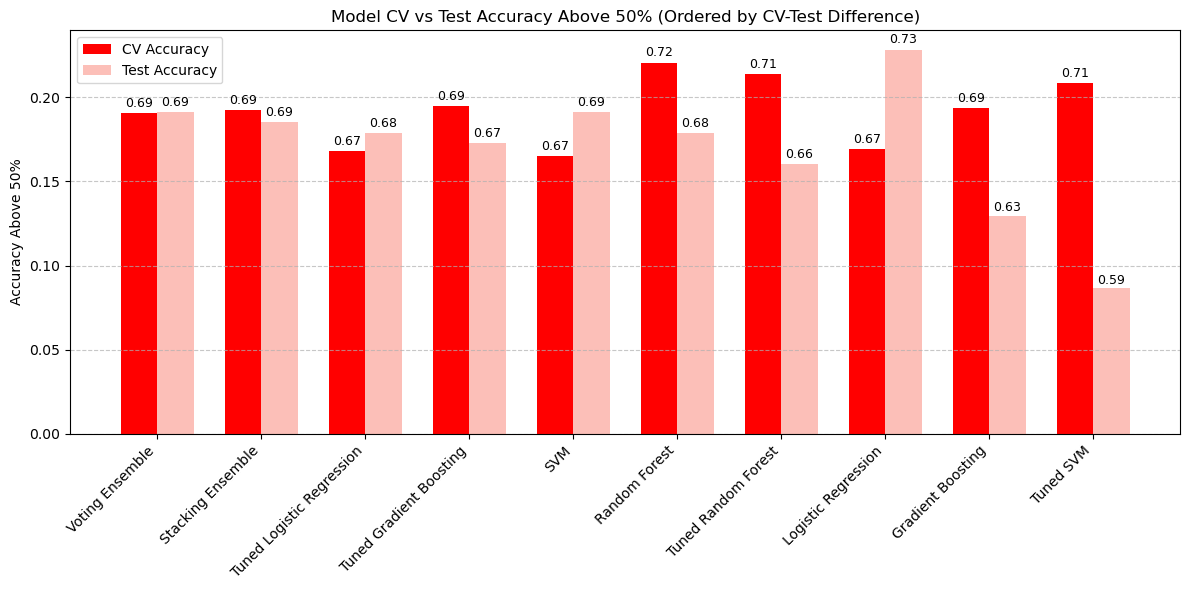

In [145]:
df = pd.concat([
    log_reg_metrics,
    best_log_metrics,
    rf_metrics,
    best_rf_metrics,
    gb_metrics,
    best_gb_metrics,
    svm_metrics,
    best_svm_metrics,
    ensemble_metrics,
    stack_metrics
], ignore_index=True)

models_df = df

# Subtract 0.5 for visualization
df['CV Above 50'] = df['CV Accuracy'] - 0.5
df['Test Above 50'] = df['Test Accuracy'] - 0.5

# Absolute difference between CV and Test
df['CV-Test Diff'] = abs(df['CV Above 50'] - df['Test Above 50'])

# Filter to positive values only
df_filtered = df[(df['CV Above 50'] > 0) | (df['Test Above 50'] > 0)]

# Order by CV-Test difference
df_filtered = df_filtered.sort_values('CV-Test Diff')

indices = np.arange(len(df_filtered))
bar_width = 0.35

plt.figure(figsize=(12,6))
bars_cv = plt.bar(indices - bar_width/2, df_filtered['CV Above 50'], width=bar_width, label='CV Accuracy', color='red')
bars_test = plt.bar(indices + bar_width/2, df_filtered['Test Above 50'], width=bar_width, label='Test Accuracy', color='salmon', alpha=0.5)

# Add exact values on top of bars
for bar in bars_cv:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01*height, f'{height+0.5:.2f}', 
             ha='center', va='bottom', fontsize=9)
for bar in bars_test:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01*height, f'{height+0.5:.2f}', 
             ha='center', va='bottom', fontsize=9)

plt.xticks(indices, df_filtered['Model'], rotation=45, ha='right')
plt.ylabel('Accuracy Above 50%')
plt.title('Model CV vs Test Accuracy Above 50% (Ordered by CV-Test Difference)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

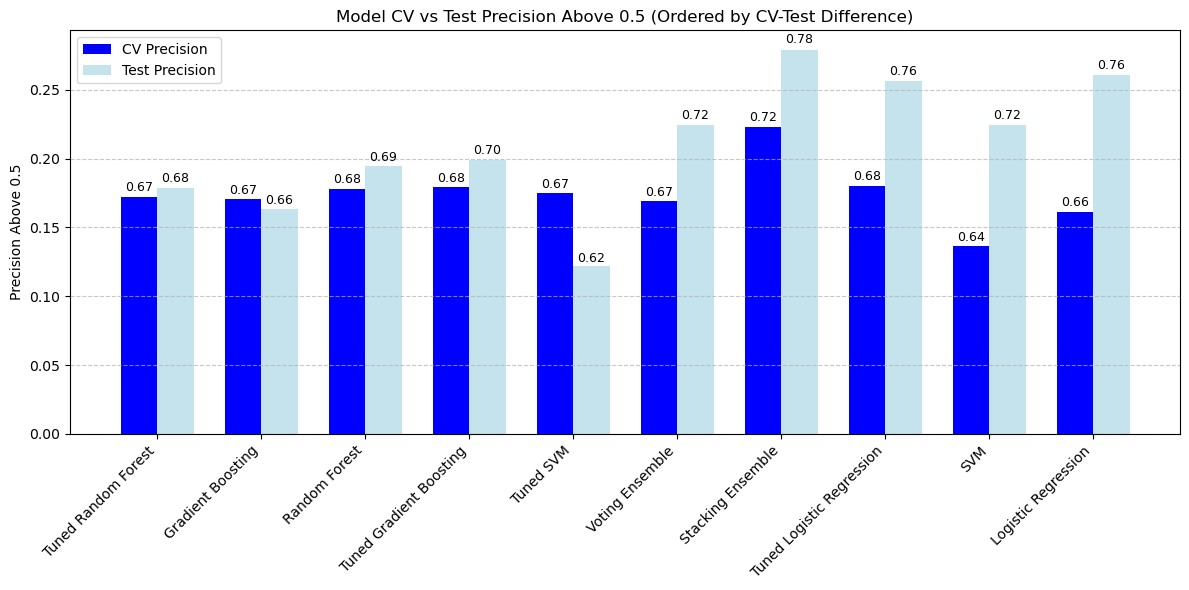

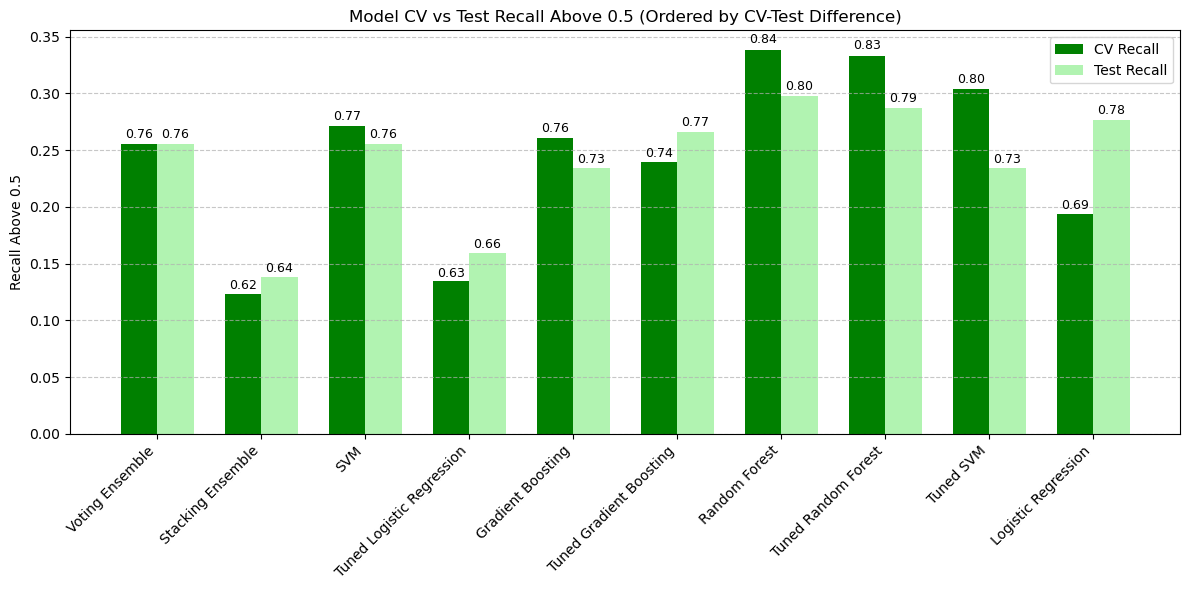

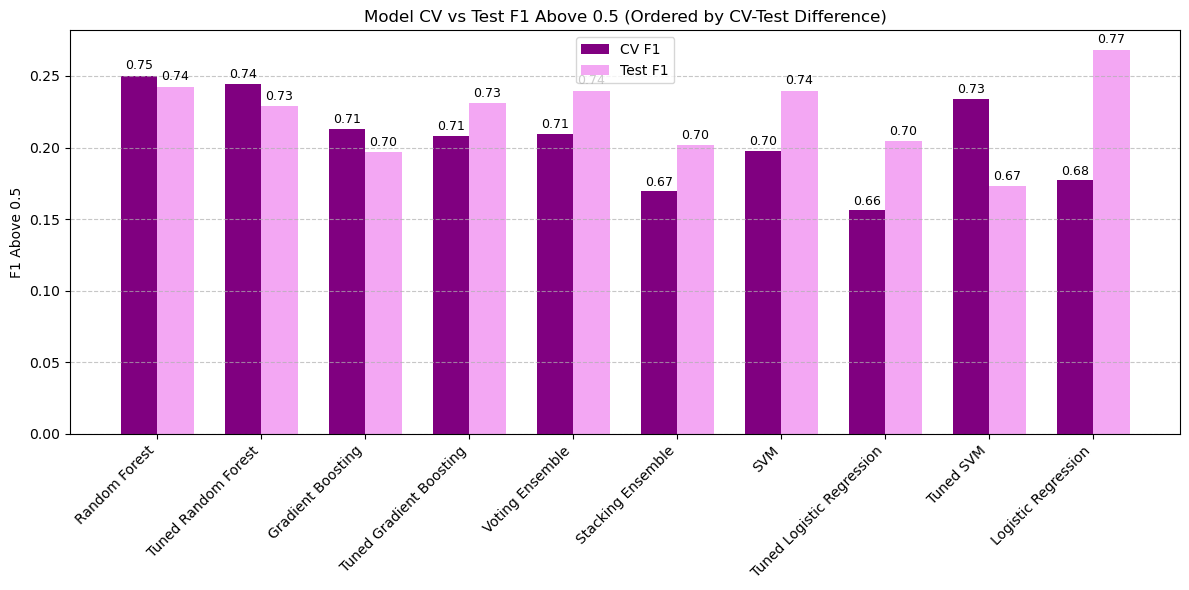

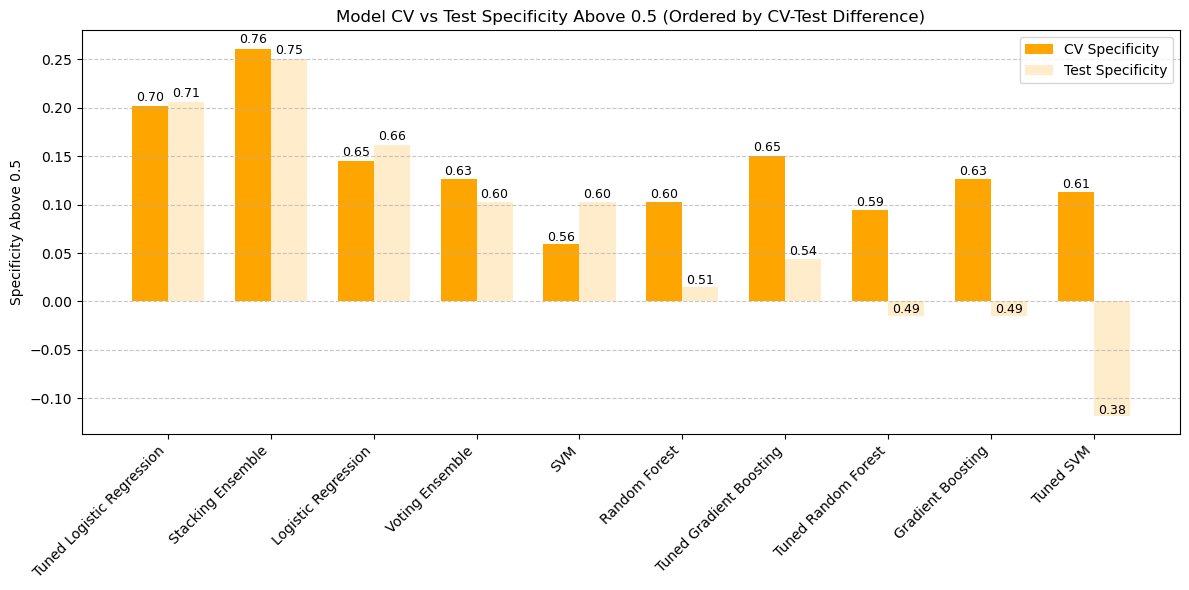

In [245]:
final_eval = df

# Function to compute metrics from a confusion matrix
def compute_metrics(cm):
    TN, FP, FN, TP = cm.ravel()
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    return precision, recall, f1, specificity

# Function to convert string-like confusion matrices to numpy arrays
def parse_cm(cm):
    return np.array(eval(cm)) if isinstance(cm, str) else np.array(cm)

cv_metrics, test_metrics = [], []

# Compute metrics for each row in the final evaluation dataframe
for _, row in final_eval.iterrows():
    # Compute CV metrics
    cv_metrics.append(compute_metrics(parse_cm(row['CV Confusion Matrix'])))
    # Compute Test metrics
    test_metrics.append(compute_metrics(parse_cm(row['Test Confusion Matrix'])))

# Convert CV metrics to DataFrame
cv_metrics_df = pd.DataFrame(cv_metrics, columns=['Precision', 'Recall', 'F1', 'Specificity'])
cv_metrics_df['Model'] = final_eval['Model']

# Convert Test metrics to DataFrame
test_metrics_df = pd.DataFrame(test_metrics, columns=['Precision', 'Recall', 'F1', 'Specificity'])
test_metrics_df['Model'] = final_eval['Model']

metrics_to_plot = ['Precision', 'Recall', 'F1', 'Specificity']
colors = {
    'Precision': ('blue', 'lightblue'),
    'Recall': ('green', 'lightgreen'),
    'F1': ('purple', 'violet'),
    'Specificity': ('orange', 'moccasin')
}

# Plot each metric CV vs Test
for metric in metrics_to_plot:
    # Extract CV and Test values
    cv_vals = cv_metrics_df[metric]
    test_vals = test_metrics_df[metric]
    diff = abs(cv_vals - test_vals)  # Compute difference for sorting
    
    # Create a DataFrame for plotting
    df_metric = pd.DataFrame({
        'Model': cv_metrics_df['Model'],
        'CV': cv_vals - 0.5,       # shift for visualization
        'Test': test_vals - 0.5,
        'Diff': diff
    })
    
    # Sort by CV-Test difference (lowest first)
    df_metric_sorted = df_metric.sort_values('Diff')
    indices = np.arange(len(df_metric_sorted))
    bar_width = 0.35
    
    plt.figure(figsize=(12,6))
    # Plot CV bars
    bars_cv = plt.bar(indices - bar_width/2, df_metric_sorted['CV'], width=bar_width, 
                      color=colors[metric][0], label='CV ' + metric)
    # Plot Test bars
    bars_test = plt.bar(indices + bar_width/2, df_metric_sorted['Test'], width=bar_width, 
                        color=colors[metric][1], alpha=0.7, label='Test ' + metric)
    
    # Annotate CV bars with actual values
    for bar in bars_cv:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01*height, f'{height+0.5:.2f}', 
                 ha='center', va='bottom', fontsize=9)
    
    # Annotate Test bars with actual values
    for bar in bars_test:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01*height, f'{height+0.5:.2f}', 
                 ha='center', va='bottom', fontsize=9)
    
    # Set plot labels and title
    plt.xticks(indices, df_metric_sorted['Model'], rotation=45, ha='right')
    plt.ylabel(f'{metric} Above 0.5')
    plt.title(f'Model CV vs Test {metric} Above 0.5 (Ordered by CV-Test Difference)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

The analysis shows that ensemble models, like Voting and Stacking, offer the most consistent performance, with minimal CV-Test differences, indicating strong generalization. Individual models, such as Tuned SVM, can achieve high CV accuracy but often drop on the test set, suggesting overfitting. Confusion matrices reveal trade-offs between precision and recall across models, with ensembles providing the best balance of accuracy and stability. The voting ensemble model will be used in future predictions.

# 4. Future Predictions

Now I will use the ensemble model to predict the outcome of the current week's games. (Round 21 2025)

The following functions will be used to facilitate the predictions:

- The future_match_id function generates a unique numeric ID for a future match by hashing its details (teams, venue, season, round, date).

- The predict_match function uses match and player data to build features for a new game. It then applies the trained model to estimate win probabilities and predicts the likely winner based on a chosen threshold. 

- The predict_round_games function predicts winners and win probabilities for all games in a round and returns the results in a single DataFrame.

In [148]:
def future_match_id(home_team, away_team, venue, season, round_n, date):
    num = abs(hash((home_team, away_team, venue, season, round_n, date))) % 1000
    return int(f"999{num:03d}")

In [149]:
def predict_match(home_team, away_team, venue, season, round_n, date, 
                  h_missing_players, h_returning_players, 
                  a_missing_players, a_returning_players, 
                  model, feature_data, stats, threshold=0.5):
    
    # assign a unique match_id for this prediction
    match_id = future_match_id(home_team, away_team, venue, season, round_n, date)
    
    # create match data
    match_dict = {
        "Date": date,
        "Match_id": match_id,
        "Season": season,
        "Home.Team": home_team,
        "Away.Team": away_team,
        "Venue": venue,
        "Round": round_n,
    }
    match_df = pd.DataFrame([match_dict])
    new_games = pd.concat([feature_data, match_df], ignore_index=True)  # use passed-in feature_data
    
    # create home/away team stats
    stats_df1 = pd.DataFrame([{
        "Match_id": match_id,
        "Season": season,
        "Team": home_team,
        "Venue": venue,
        "Round": round_n,
        "Missing_Players": h_missing_players,
        "Returning_Players": h_returning_players
    }])
    stats_df2 = pd.DataFrame([{
        "Match_id": match_id,
        "Season": season,
        "Team": away_team,
        "Venue": venue,
        "Round": round_n,
        "Missing_Players": a_missing_players,
        "Returning_Players": a_returning_players
    }])
    
    # combine stats
    new_stats = pd.concat([stats, stats_df1, stats_df2], ignore_index=True)
    
    # generate features only for this match
    match_features = add_all_features(new_games, stats=new_stats, years=[season]).query("Match_id == @match_id")
    
    X_train_columns = [
        'NetMeanRating', 'HomeMeanRating', 'AwayMeanRating', 
        'HomeForms', 'AwayForms', 'HomeLast5MatchupWinRate', 
        'HomeVenueWinRate', 'AwayVenueWinRate', 'HomeElo', 
        'AwayElo', 'home_days_since', 'away_days_since',
        'NetHomeElo', 'HomeNetForm'
    ]
    
    # select features used for training
    X_new = match_features[X_train_columns]

    # make predictions
    predicted_proba = model.predict_proba(X_new)[0]
    predicted_class = 1 if predicted_proba[1] >= threshold else 0
    
    # add prediction to dataframe
    result_df = match_features.copy()
    result_df["PredictedWinner"] = "Away" if predicted_class == 0 else "Home"
    result_df["PredictedProb_AwayWin"] = predicted_proba[0]
    result_df["PredictedProb_HomeWin"] = predicted_proba[1]
    
    return result_df


In [150]:
def predict_round_games(fixtures, model, games, stats,
                        missing_players_dict=None, returning_players_dict=None, threshold=0.5):
    # Create empty player dicts if none given
    if missing_players_dict is None:
        teams = set([f[0] for f in fixtures] + [f[1] for f in fixtures])
        missing_players_dict = {team: [] for team in teams}
    if returning_players_dict is None:
        teams = set([f[0] for f in fixtures] + [f[1] for f in fixtures])
        returning_players_dict = {team: [] for team in teams}
    
    all_predictions = []

    for game in fixtures:
        home_team, away_team, venue, season, round_n, date = game
        
        # Clean venue
        venue = venue.strip().lower()
        
        # Get player info
        h_missing_players = missing_players_dict.get(home_team, [])
        a_missing_players = missing_players_dict.get(away_team, [])
        h_returning_players = returning_players_dict.get(home_team, [])
        a_returning_players = returning_players_dict.get(away_team, [])
        
        # Run prediction
        result = predict_match(
            home_team=home_team,
            away_team=away_team,
            venue=venue,
            season=season,
            round_n=round_n,
            date=date,
            h_missing_players=h_missing_players,
            a_missing_players=a_missing_players,
            h_returning_players=h_returning_players,
            a_returning_players=a_returning_players,
            model=model,
            feature_data=games,
            stats=stats,
            threshold=threshold
        )
        
        all_predictions.append(result)
    
    # Collect results
    final_predictions_df = pd.concat(all_predictions, ignore_index=True)[[
        'Home.Team', 'Away.Team', 'PredictedWinner', 
        'PredictedProb_HomeWin', 'PredictedProb_AwayWin'
    ]]
    
    return final_predictions_df

In [154]:
round21_games_2025 = [
    # Round 21, 2025 fixtures: [Home, Away, Venue, Season, Round, Date]
    ['Western Bulldogs', 'GWS', 'Marvel Stadium', 2025, 21, '31-07-2025'],
    ['Adelaide', 'Hawthorn', 'Adelaide Oval', 2025, 21, '01-08-2025'],
    ['Melbourne', 'West Coast', 'Marvel Stadium', 2025, 21, '01-08-2025'],
    ['Gold Coast', 'Richmond', 'People First Stadium', 2025, 21, '02-08-2025'],
    ['Sydney', 'Essendon', 'SCG', 2025, 21, '02-08-2025'],
    ['Collingwood', 'Brisbane', 'MCG', 2025, 21, '02-08-2025'],
    ['St Kilda', 'North Melbourne', 'Marvel Stadium', 2025, 21, '02-08-2025'],
    ['Geelong', 'Port Adelaide', 'GMHBA Stadium', 2025, 21, '03-08-2025'],
    ['Fremantle', 'Carlton', 'Optus Stadium', 2025, 21, '03-08-2025']
]

# Use the trained ensemble model
voting_ensemble = ensemble

# Get the threshold for the Voting Ensemble model
threshold = models_df[models_df['Model'] == 'Voting Ensemble']['Threshold'].values[0]

# Run predictions for all Round 21 games
round21_predictions = predict_round_games(
    fixtures=round21_games_2025,  
    model=voting_ensemble,         
    games=games,                   
    stats=stats,                   
    missing_players_dict=None,     
    returning_players_dict=None,   
    threshold=threshold           
)

In [155]:
round21_predictions

,Home.Team,Away.Team,PredictedWinner,PredictedProb_HomeWin,PredictedProb_AwayWin
0,Western Bulldogs,GWS,Away,0.401425,0.598575
1,Adelaide,Hawthorn,Home,0.583622,0.416378
2,Melbourne,West Coast,Home,0.714966,0.285034
3,Gold Coast,Richmond,Home,0.830753,0.169247
4,Sydney,Essendon,Home,0.717337,0.282663
5,Collingwood,Brisbane,Home,0.532858,0.467142
6,St Kilda,North Melbourne,Home,0.612503,0.387497
7,Geelong,Port Adelaide,Home,0.597165,0.402835
8,Fremantle,Carlton,Home,0.675770,0.324230


For Round 21, 2025, the Voting Ensemble model correctly predicted 7 out of 9 AFL matches. The two misclassifications were:

Western Bulldogs vs. GWS → Predicted Away (P(Home) = 0.40, P(Away) = 0.60)

Collingwood vs. Brisbane → Predicted Home (P(Home) = 0.53, P(Away) = 0.47)

Both incorrect predictions occurred when the predicted probabilities were relatively similar, indicating the model only struggled in closely contested matchups. This is a positive outcome, as it suggests the model performs well when probabilities are more decisive.

# 5. Dynamic Data Processing and Forecasting
Here we can import up-to-date scraped data, automatically process it, and generate predictions for the current round. Additionally, the model can be retrained on new data to continuously improve forecasting accuracy.

In [168]:
def preprocess_afl_data(stats_2025, games_2025):
    # Load and concatenate historical stats data
    stats_2015 = pd.read_csv('../data/footywire_player_stats_2015.csv')
    stats_2016 = pd.read_csv('../data/footywire_player_stats_2016.csv')
    stats_2017 = pd.read_csv('../data/footywire_player_stats_2017.csv')
    stats_2018 = pd.read_csv('../data/footywire_player_stats_2018.csv')
    stats_2019 = pd.read_csv('../data/footywire_player_stats_2019.csv')
    stats_2020 = pd.read_csv('../data/footywire_player_stats_2020.csv')
    stats_2021 = pd.read_csv('../data/footywire_player_stats_2021.csv')
    stats_2022 = pd.read_csv('../data/footywire_player_stats_2022.csv')
    stats_2023 = pd.read_csv('../data/footywire_player_stats_2023.csv')
    stats_2024 = pd.read_csv('../data/footywire_player_stats_2024.csv')
    stats = pd.concat([stats_2015, stats_2016, stats_2017, stats_2018, stats_2019, 
                       stats_2020, stats_2021, stats_2022, stats_2023, stats_2024, 
                       stats_2025], ignore_index=True)

    # Load and concatenate historical games data
    games_2015 = pd.read_csv('../data/footywire_match_results_2015.csv')
    games_2016 = pd.read_csv('../data/footywire_match_results_2016.csv')
    games_2017 = pd.read_csv('../data/footywire_match_results_2017.csv')
    games_2018 = pd.read_csv('../data/footywire_match_results_2018.csv')
    games_2019 = pd.read_csv('../data/footywire_match_results_2019.csv')
    games_2020 = pd.read_csv('../data/footywire_match_results_2020.csv')
    games_2021 = pd.read_csv('../data/footywire_match_results_2021.csv')
    games_2022 = pd.read_csv('../data/footywire_match_results_2022.csv')
    games_2023 = pd.read_csv('../data/footywire_match_results_2023.csv')
    games_2024 = pd.read_csv('../data/footywire_match_results_2024.csv')
    games = pd.concat([games_2015, games_2016, games_2017, games_2018, games_2019, 
                       games_2020, games_2021, games_2022, games_2023, games_2024, 
                       games_2025], ignore_index=True)

    # Drop NA values from stats
    stats = stats.dropna()
    
    # Remove unusual characters from 'Player' names and strip whitespace
    stats['Player'] = stats['Player'].str.replace(r"[^\w\s'-]", '', regex=True).str.strip()
    
    # Drop unnecessary columns from stats
    stats = stats.drop(columns=['AF', 'SC'], errors='ignore')  # 'errors=ignore' avoids KeyError if columns missing
    
    # Flag if the home team won (1) or not (0)
    games['HomeWin'] = (games['Home.Points'] > games['Away.Points']).astype(int)
    
    # Flag if the away team won (1) or not (0)
    games['AwayWin'] = (games['Away.Points'] > games['Home.Points']).astype(int)
    
    # Determine the winner's name, or 'Draw' if points are equal
    games['Winner'] = np.where(games['HomeWin'], games['Home.Team'],
                              np.where(games['AwayWin'], games['Away.Team'], 'Draw'))
    
    # Convert 'Date' to datetime and extract 'Season'
    games['Date'] = pd.to_datetime(games['Date'])
    games['Season'] = games['Date'].dt.year
    
    # Prepare stats subset for merging (rename 'Team' to 'Home.Team')
    merge_stats = stats[['Match_id', 'Round', 'Team', 'Season']].rename(columns={'Team': 'Home.Team'})
    
    # Merge, drop duplicates, and reset index
    games = games.merge(merge_stats, on=['Round', 'Home.Team', 'Season'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Define finals mapping
    finals_map = {
        'Qualifying Final': 25,
        'Elimination Final': 25,
        'Semi Final': 26,
        'Preliminary Final': 27,
        'Preliminary Finals': 27,
        'Grand Final': 28
    }
    
    # Apply finals mapping and convert 'Round' in games to integers
    games['Round'] = games['Round'].replace(finals_map)
    games['Round'] = games['Round'].replace(r'Round (\d+)', r'\1', regex=True).astype(int)
    
    # Apply finals mapping and convert 'Round' in stats to integers
    stats['Round'] = stats['Round'].replace(finals_map)
    stats['Round'] = stats['Round'].replace(r'Round (\d+)', r'\1', regex=True).astype(int)
    
    # Normalize venue names
    venue_fix = {' Marvel Stadium': 'Marvel Stadium'}
    stats['Venue'] = stats['Venue'].replace(venue_fix)
    games['Venue'] = games['Venue'].replace(venue_fix)
    
    return stats, games

In [177]:
def retrain_model(stats, games):
    final = add_all_features(games, stats, list(range(2022, 2026)))
    
    # Select features (X) and target variable (y)
    X = final[['NetMeanRating', 'HomeMeanRating', 'AwayMeanRating', 'HomeForms', 'AwayForms', 
               'HomeLast5MatchupWinRate', 'HomeVenueWinRate', 'AwayVenueWinRate', 'HomeElo', 
               'AwayElo', 'home_days_since', 'away_days_since', 'NetHomeElo', 'HomeNetForm']]
    y = final['HomeWin']
    
    # Split into training (80%) and testing (20%) sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE to balance the training set (oversample the minority class)
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    # Tune the Logistic Regression model
    best_log = tune_model(
        LogisticRegression(max_iter=5000, random_state=42), 
        log_param_grid, 
        X_train, y_train, 
        X_test, y_test, 
        model_name="Logistic Regression"
    )
    
    # Tune the Random Forest model
    best_rf = tune_model(
        RandomForestClassifier(random_state=42), 
        rf_param_grid, 
        X_train, y_train, 
        X_test, y_test, 
        "Random Forest"
    )
    
    # Tune the Gradient Boosting model
    best_gb = tune_model(
        GradientBoostingClassifier(random_state=42), 
        gb_param_grid, 
        X_train, y_train, 
        X_test, y_test, 
        "Gradient Boosting"
    )
    
    # Initialize the Support Vector Machine model (no tuning due to unscaled features)
    svm_model = SVC(
        kernel='rbf',      
        C=1.0,             
        gamma='scale',     
        probability=True,  
        random_state=42    
    )
    
    # Train the SVM model on the training data
    svm_model.fit(X_train, y_train)
    
    # Create and train the ensemble model using soft voting
    ensemble = VotingClassifier(
        estimators=[
            ('svm', svm_model),
            ('gb', best_gb),
            ('rf', best_rf),
            ('log', best_log)
        ],
        voting='soft',
        weights=[2, 1, 1, 1],  # Higher weight for SVM
        n_jobs=-1
    )
    
    # Train the ensemble model
    ensemble.fit(X_train, y_train)
    
    # Determine optimal threshold based on accuracy
    y_pred_proba = ensemble.predict_proba(X_test)[:, 1]  # Probability of HomeWin
    thresholds = np.arange(0.1, 1.0, 0.1)
    best_threshold = 0.5
    best_accuracy = accuracy_score(y_test, (y_pred_proba >= 0.5).astype(int))
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    return ensemble, best_threshold

In [169]:
stats_2025 = pd.read_csv('../data/new_footywire_player_stats_2025.csv')
games_2025 = pd.read_csv('../data/new_footywire_match_results_2025.csv')

new_stats, new_games = preprocess_afl_data(stats_2025, games_2025)

In [172]:
round24_games_2025 = [
    ['Essendon', 'Carlton', 'MCG', 2025, 24, '2025-08-21'],
    ['Collingwood', 'Melbourne', 'MCG', 2025, 24, '2025-08-22'],
    ['Port Adelaide', 'Gold Coast', 'Adelaide Oval', 2025, 24, '2025-08-22'],
    ['North Melbourne', 'Adelaide', 'Marvel Stadium', 2025, 24, '2025-08-22'],
    ['Richmond', 'Geelong', 'MCG', 2025, 24, '2025-08-23'],
    ['West Coast', 'Sydney', 'Optus Stadium', 2025, 24, '2025-08-23'],
    ['GWS', 'St Kilda', 'ENGIE Stadium', 2025, 24, '2025-08-23'],
    ['Western Bulldogs', 'Fremantle', 'Marvel Stadium', 2025, 24, '2025-08-24'],
    ['Brisbane', 'Hawthorn', 'Gabba', 2025, 24, '2025-08-24'],
    ['Gold Coast', 'Essendon', 'People First Stadium', 2025, 24, '2025-08-27']
]

# Use the trained ensemble model
voting_ensemble = ensemble

# Get the threshold for the Voting Ensemble model
threshold = models_df[models_df['Model'] == 'Voting Ensemble']['Threshold'].values[0]

# Run predictions for all games
round24_predictions = predict_round_games(
    fixtures=round24_games_2025,  
    model=voting_ensemble,         
    games=new_games,                   
    stats=new_stats,                   
    missing_players_dict=None,     
    returning_players_dict=None,   
    threshold=threshold           
)

In [173]:
round24_predictions

,Home.Team,Away.Team,PredictedWinner,PredictedProb_HomeWin,PredictedProb_AwayWin
0,Essendon,Carlton,Away,0.260495,0.739505
1,Collingwood,Melbourne,Home,0.718870,0.281130
2,Port Adelaide,Gold Coast,Away,0.199973,0.800027
3,North Melbourne,Adelaide,Away,0.118017,0.881983
4,Richmond,Geelong,Away,0.100798,0.899202
5,West Coast,Sydney,Away,0.153089,0.846911
6,GWS,St Kilda,Home,0.651652,0.348348
7,Western Bulldogs,Fremantle,Home,0.537080,0.462920
8,Brisbane,Hawthorn,Home,0.569640,0.430360
9,Gold Coast,Essendon,Home,0.853627,0.146373
